In [126]:

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import shutil
from shutil import copyfile
import time

In [127]:
def check_mask_nearby_ij(i,j,mask,ndist):
    # i = index along i of point to test
    # j = index along j of point to test
    # mask = 2D mask 
    # ndist = distance from center to check
    if (i > (ndist-1)):
        TEST_i = np.nansum(mask[i-ndist:i+ndist+1,j])
    else:
        TEST_i = np.nansum(mask[i:i+ndist+1,j])
    if (j > (ndist-1)):
        TEST_j = np.nansum(mask[i,j-ndist:j+ndist+1])
    else:
        TEST_j = np.nansum(mask[i,j:j+ndist+1])
    return TEST_i, TEST_j    


In [128]:
def get_npoints_ij(i,j,mask,ndist,rnf_data):
        # return the number of sea points at ndist distance
        arr= np.array([rnf_data[i-ndist,j] + mask[i-ndist,j], \
                    rnf_data[i+ndist,j]    + mask[i+ndist,j],    \
                    rnf_data[i,j-ndist]   + mask[i,j-ndist],   \
                    rnf_data[i,j+ndist]   + mask[i,j+ndist]])
        ind=np.array(np.argwhere(arr==0))
        if len(ind>0):
            return len(ind)
        else:
            ind=np.array(np.argwhere(arr<1))
            return len(ind)



In [129]:
def check_if_surrounded_by_land(i,j,mask,ndist):
    surrounded_by_land=0
    dim_i , dim_j =int(len(mask[:,0])),int(len(mask[0,:]))
    # i = index along i of point to test
    # j = index along j of point to test
    # mask = 2D mask 
    # ndist = distance from center to check
    if (i > (ndist-1)):
        if (j > (ndist-1)):
            npts = np.nansum(mask[i-ndist:i+ndist+1,j-ndist:j+ndist+1])
            if npts == (1+(ndist*2))**2 :
                surrounded_by_land=1
        else:
            npts = np.nansum(mask[i-ndist:i+ndist+1,j:j+ndist+1])
            if npts == (1+(ndist*2))*(1+(ndist*2)-ndist) :
                surrounded_by_land=1
    else:
        if (j > (ndist-1)):
            npts = np.nansum(mask[i:i+ndist+1,j-ndist:j+ndist+1])
            if npts == (1+(ndist*2))*(1+(ndist*2)-ndist):
                surrounded_by_land=1
        else:
            npts = np.nansum(mask[i:i+ndist+1,j:j+ndist+1])
            if npts == (1+(ndist*2)-ndist)*(1+(ndist*2)-ndist) :
                surrounded_by_land=1

    if (i < ((dim_i-1) - ndist)):
        if (j < ((dim_j-1) - ndist)):
            npts = np.nansum(mask[i-ndist:i+ndist+1,j-ndist:j+ndist+1])
            if npts == (1+(ndist*2))**2 :
                surrounded_by_land=1
        else:
            npts = np.nansum(mask[i-ndist:i+ndist+1,j-ndist:j+1])
            if npts == (1+(ndist*2))*(1+(ndist*2)-ndist) :
                surrounded_by_land=1
    else:
        if (j < ((dim_j-1) - ndist)):
            npts = np.nansum(mask[i-ndist:i+ndist+1,j-ndist:j+ndist+1])
            if npts == (1+(ndist*2))*(1+(ndist*2)-ndist):
                surrounded_by_land=1
        else:
            npts = np.nansum(mask[i-ndist:i+1,j-ndist:j+ndist])
            if npts == (1+(ndist*2)-ndist)*(1+(ndist*2)-ndist) :
                surrounded_by_land=1
    return surrounded_by_land 


In [130]:
def check_if_surrounded_by_sea(i,j,mask,ndist,nseuil):
    mask_inv=np.where(mask==1,0,1)
#     if ndist <= nseuil: # search only along i,j in an nseuil in a nseuil radius
#         mask_inv_new=np.ones(mask_inv.shape)
#         mask_inv_new[ndist,:]=mask_inv[ndist,:]
#         mask_inv_new[:,ndist]=mask_inv[:,ndist]
#         mask_inv=mask_inv_new
    surrounded_by_sea=0
    dim_i , dim_j =int(len(mask_inv[:,0])),int(len(mask_inv[0,:]))
    # i = index along i of point to test
    # j = index along j of point to test
    # mask_inv = 2D mask_inv 
    # ndist = distance from center to check
    if (i > (ndist-1)):
        if (j > (ndist-1)):
            npts = np.nansum(mask_inv[i-ndist:i+ndist+1,j-ndist:j+ndist+1])
            if npts == (1+(ndist*2))**2 :
                surrounded_by_sea=1
        else:
            npts = np.nansum(mask_inv[i-ndist:i+ndist+1,j:j+ndist+1])
            if npts == (1+(ndist*2))*(1+(ndist*2)-ndist) :
                print(npts)
                surrounded_by_sea=1
    else:
        if (j > (ndist-1)):
            npts = np.nansum(mask_inv[i:i+ndist+1,j-ndist:j+ndist+1])
            if npts == (1+(ndist*2))*(1+(ndist*2)-ndist):
                surrounded_by_sea=1
        else:
            npts = np.nansum(mask_inv[i:i+ndist+1,j:j+ndist+1])
            if npts == (1+(ndist*2)-ndist)*(1+(ndist*2)-ndist) :
                surrounded_by_sea=1

    if (i < ((dim_i-1) - ndist)):
        if (j < ((dim_j-1) - ndist)):
            npts = np.nansum(mask_inv[i-ndist:i+ndist+1,j-ndist:j+ndist+1])
            if npts == (1+(ndist*2))**2 :
                surrounded_by_sea=1
        else:
            npts = np.nansum(mask_inv[i-ndist:i+ndist+1,j-ndist:j+ndist])
            if npts == (1+(ndist*2))*(1+(ndist*2)-ndist) :
                surrounded_by_sea=1
    else:
        if (j < ((dim_j-1) - ndist)):
            npts = np.nansum(mask_inv[i-ndist:i+ndist,j-ndist:j+ndist+1])
            if npts == (1+(ndist*2))*(1+(ndist*2)-ndist):
                surrounded_by_sea=1
        else:
            npts = np.nansum(mask_inv[i-ndist:i+ndist,j-ndist:j+ndist])
            if npts == (1+(ndist*2)-ndist)*(1+(ndist*2)-ndist) :
                surrounded_by_sea=1
    return surrounded_by_sea 



In [131]:
def find_nearest_sea_point(i,j,mask,ndist,rnf_data):
    i_ind_new=[]
    j_ind_new=[]
    
# First, check along i / j only
    if (i > (ndist-1)):
        if (j > (ndist-1)):
            arr = rnf_data[i-ndist:i+ndist+1,j-ndist:j+ndist+1] + mask[i-ndist:i+ndist+1,j-ndist:j+ndist+1]
        else:
            arr = rnf_data[i-ndist:i+ndist+1,j:j+ndist+1] + mask[i-ndist:i+ndist+1,j:j+ndist+1]
    else:
        if (j > (ndist-1)):
            arr = rnf_data[i:i+ndist+1,j-ndist:j+ndist+1] + mask[i:i+ndist+1,j-ndist:j+ndist+1]
        else:
            arr = rnf_data[i:i+ndist+1,j:j+ndist+1] + mask[i:i+ndist+1,j:j+ndist+1]
   
    available_points_all=np.argwhere(arr[:,:]==0)  - ndist
    available_points_all[:,0]=available_points_all[:,0] + i 
    available_points_all[:,1]=available_points_all[:,1] + j  
# First, check if there is an empty point around
    arr_ij=np.ones(arr.shape)
    if 0 in arr:
        # check along i and j axis only
        arr_ij[ndist,:]=arr[ndist,:]
        arr_ij[:,ndist]=arr[:,ndist]
        available_points_ij=np.argwhere(arr_ij[:,:]==0) - ndist
        available_points_ij[:,0]=available_points_ij[:,0] + i 
        available_points_ij[:,1]=available_points_ij[:,1] + j 
    if 0 in arr_ij :
        return available_points_ij
    else: # If no empty point, return the closests sea points
        
        if (i > (ndist-1)):
            if (j > (ndist-1)):
                arr = mask[i-ndist:i+ndist+1,j-ndist:j+ndist+1]
            else:
                arr = mask[i-ndist:i+ndist+1,j:j+ndist+1]
        else:
            if (j > (ndist-1)):
                arr = mask[i:i+ndist+1,j-ndist:j+ndist+1]
            else:
                arr = mask[i:i+ndist+1,j:j+ndist+1]  
                
        available_points_all=np.argwhere(arr[:,:]==0)  - ndist
        available_points_all[:,0]=available_points_all[:,0] + i 
        available_points_all[:,1]=available_points_all[:,1] + j  
        if 0 in arr:
            arr_ij=np.ones(arr.shape)
            arr_ij[ndist,:]=arr[ndist,:]
            arr_ij[:,ndist]=arr[:,ndist]
            available_points_ij=np.argwhere(arr_ij[:,:]==0)  - ndist
            available_points_ij[:,0]=available_points_ij[:,0] + i 
            available_points_ij[:,1]=available_points_ij[:,1] + j 
            if 0 in arr_ij :
                return available_points_ij
            else:
                return available_points_all
            del(available_points_all, available_points_ij)
        else:
            print("ERROR")
            print(arr)



In [132]:
def get_nearest_coast_point(i,j,ndist,arr):
    available_points_all=np.argwhere(arr[:,:]==0)
    if i < (ndist - 1):
        if j< (ndist - 1):
            available_points_all[:,0]=available_points_all[:,0] + i - (ndist - 1)
            available_points_all[:,1]=available_points_all[:,1] + j - (ndist - 1) 
            available_points_all[:,0]=np.where(available_points_all[:,0]>i,available_points_all[:,0]-1,available_points_all[:,0])
            available_points_all[:,1]=np.where(available_points_all[:,1]>j,available_points_all[:,1]-1,available_points_all[:,1])             
        else:       
            available_points_all[:,0]=available_points_all[:,0] + i - (ndist - 1)
            available_points_all[:,1]=available_points_all[:,1] + j - ndist
            available_points_all[:,0]=np.where(available_points_all[:,0]<i,available_points_all[:,0]+1,available_points_all[:,0])
            available_points_all[:,0]=np.where(available_points_all[:,0]>i,available_points_all[:,0]-1,available_points_all[:,0])
            available_points_all[:,1]=np.where(available_points_all[:,1]<j,available_points_all[:,1]+1,available_points_all[:,1])
            available_points_all[:,1]=np.where(available_points_all[:,1]>j,available_points_all[:,1]-1,available_points_all[:,1])
    else:   
        available_points_all[:,0]=available_points_all[:,0] + i - ndist 
        available_points_all[:,1]=available_points_all[:,1] + j - ndist
        available_points_all[:,0]=np.where(available_points_all[:,0]<i,available_points_all[:,0]+1,available_points_all[:,0])
        available_points_all[:,0]=np.where(available_points_all[:,0]>i,available_points_all[:,0]-1,available_points_all[:,0])
        available_points_all[:,1]=np.where(available_points_all[:,1]<j,available_points_all[:,1]+1,available_points_all[:,1])
        available_points_all[:,1]=np.where(available_points_all[:,1]>j,available_points_all[:,1]-1,available_points_all[:,1])

    return(available_points_all)


In [133]:
def find_nearest_coast_point(i,j,mask,ndist,rnf_data):
    mask_inv=np.where(mask==1,0,1)
    i_ind_new=[]
    j_ind_new=[]
    idim ,jdim = int(len(mask[:,0])), int(len(mask[0,:]))
# First, check if there is an empty point around    
    if (i > (ndist-1)):
        if (j > (ndist-1)):
            arr = rnf_data[i-ndist:i+ndist+1,j-ndist:j+ndist+1] + mask_inv[i-ndist:i+ndist+1,j-ndist:j+ndist+1]
        else:
            arr = rnf_data[i-ndist:i+ndist+1,j:j+ndist+1] + mask_inv[i-ndist:i+ndist+1,j:j+ndist+1]
    else:
        if (j > (ndist-1)):
            arr = rnf_data[i:i+ndist+1,j-ndist:j+ndist+1] + mask_inv[i:i+ndist+1,j-ndist:j+ndist+1]
        else:
            arr = rnf_data[i:i+ndist+1,j:j+ndist+1] + mask_inv[i:i+ndist+1,j:j+ndist+1]

    arr_ij=np.ones(arr.shape)
    if 0 in arr:
        arr_ij[ndist,:]=arr[ndist,:]
        arr_ij[:,ndist]=arr[:,ndist]
    if 0 in arr_ij :
        # check along i and j axis only
        available_points = get_nearest_coast_point(i,j,ndist,arr_ij)
    
# Then, if no empty point, return the closests sea points
    else: 
        
        if (i > (ndist-1)):
            if (j > (ndist-1)):
                arr = mask_inv[i-ndist:i+ndist+1,j-ndist:j+ndist+1]
            else:
                arr = mask_inv[i-ndist:i+ndist+1,j:j+ndist+1]
        else:
            if (j > (ndist-1)):
                arr = mask_inv[i:i+ndist+1,j-ndist:j+ndist+1]
            else:
                arr = mask_inv[i:i+ndist+1,j:j+ndist+1]  
        if 0 in arr:
            arr_ij=np.ones(arr.shape)
            arr_ij[ndist,:]=arr[ndist,:]
            arr_ij[:,ndist]=arr[:,ndist]
            if 0 in arr_ij :
                # check along i and j axis only
                available_points = get_nearest_coast_point(i,j,ndist,arr_ij)
            else:
                available_points = get_nearest_coast_point(i,j,ndist,arr)
        else:
            print("ERROR")
            print(arr)
    return available_points


In [134]:
def move_runoffs(rnf_2Dt,rnf_point,mask,lverb):
# --------------------------------------------------------------------------------------------------
# PURPOSE :
# Check runoff data and move data off the coast or over land at the first available point near the coast
# ------------------------------------
# CASE 1 : Runoff point is over land : 
# find the nearest(s) sea point(s) and return its (their) index : ind=(i,j) or ind(i1,j1,i2,j2....)
# 2 possibilities : 
#    => At least one runoff value at ind=(in,jn) is 0.0 : move data over this point
#    => No runoff value at ind=(in,jn) is > 0.0 : add runoff value to this point
# When more than one sea point is found (ind(i1,j1,i2,j2....)), the runoff is averaged over every points
#
# ------------------------------------
# CASE 2 : Runoff point is surrounded by sea : 
# Find the nearest coast point
# If more than one coast points are available, average avor the two coast points
#
#
# --------------------------------------------------------------------------------------------------
# Inputs : 
# rnf_2D = runoff data in 2 dimension
# rnf_point = array with indexes of rnf points (should have the form : (2,N), 
# where N is the number of runoff points)
# mask = output mask (1 over sea points and 0 over land points)
# lverb = verbose (True or False)
# --------------------------------------------------------------------------------------------------
# Output : New 2D array with moved runoffs
# --------------------------------------------------------------------------------------------------

# Initialisation
    nseuil=30 # over 30 points distance, do not replace runoff
    rnf_2D=rnf_2Dt[0,:,:]
    rnf_2Dt_new = np.copy(rnf_2Dt)
#     rnf_2Dt_new[:,:,:] = 0.

    mask_data=mask
    mask_data=np.where(mask_data==1,0,1) # invert mask
    sea_point_not_found=0.
    land_point_not_found=0.
    ndist=1
    
# --------------------------------------------------------------------------------------------------
# BEGIN LOOP
    print(len(rnf_point[0,:]))
# Loop over valid runoff values only  
    for n in range(len(rnf_point[0,:])): 
        print("treating runoff point ",rnf_point[0,n],rnf_point[1,n], n, "/", len(rnf_point[0,:]))
        
        if (mask_data[rnf_point[0,n],rnf_point[1,n]]==1): # POINT IS OVER LAND ------------
            surrounded = check_if_surrounded_by_land(rnf_point[0,n],\
                                                           rnf_point[1,n],mask_data,ndist)
            if lverb: print("==> j, i = ", rnf_point[0,n],rnf_point[1,n],                    \
                            "is on mask point")

            if surrounded == 1: # Surrounded by earth
                if (ndist > nseuil): 
                    if lverb: print("WARNING !!! : closest sea point is over ",nseuil,"\
                    point perimeter at i, j = ", rnf_point[0,n],rnf_point[1,n])

                while sea_point_not_found == 0:
                    surrounded = check_if_surrounded_by_land(rnf_point[0,n],\
                                                           rnf_point[1,n],mask_data,ndist)

                    if surrounded == 1: # No sea point in ndist perimeter 
                        if lverb: print(rnf_point[0,n],rnf_point[1,n],\
                                        "surrounded by earth points, trying ndist=+1;",      \
                                        "next radius = ", (1+((ndist+1)*2)))
                    else: # At least one sea point in ndist perimeter
                        sea_point_not_found=1.
                        indexes_closests_sea_point=find_nearest_sea_point(rnf_point[0,n],rnf_point[1,n],          \
                                                     mask_data,ndist,rnf_2D)

                    ndist=ndist+1
  
            else: # AT LEAST ONE SEA POINT in ndist=1 perimeter ------------
                indexes_closests_sea_point=find_nearest_sea_point(rnf_point[0,n],rnf_point[1,n],mask_data,        \
                                             ndist,rnf_2D)
    # NOW REPLACE RUNOFFS
            npoints=len(indexes_closests_sea_point[:,0])
            # Now replace data
            if npoints == 0: 
                # No available points nearby without an already existing runoff value => avoid
                #rnf_2Dt_new[:,rnf_point[0,n],rnf_point[1,n]] = 0.  
                print(rnf_point[0,n],rnf_point[1,n],"ISSUE AT THIS POINT !!")
            else: 
                for ind in range(npoints):
                    if lverb: print("moving point over ", npoints, "points : i,j ",ind + 1, "/",npoints, ":"\
                        ,"=",int(indexes_closests_sea_point[ind,0]),int(indexes_closests_sea_point[ind,1])  ) 
                    rnf_2Dt_new[:,rnf_point[0,n],rnf_point[1,n]]=0.
                    rnf_2Dt_new[:,int(indexes_closests_sea_point[ind,0]),int(indexes_closests_sea_point[ind,1])] \
                    = rnf_2Dt_new[:,int(indexes_closests_sea_point[ind,0]),int(indexes_closests_sea_point[ind,1])]    \
                    + (rnf_2Dt[:,rnf_point[0,n],rnf_point[1,n]] / npoints) 
                    

        else: #POINT IS OVER SEA ------------
            ndist=1
            surrounded = check_if_surrounded_by_sea(rnf_point[0,n],\
                                                    rnf_point[1,n],mask_data,ndist,3)
            # Loop until we find at least one sea point in ndist perimeter$
            if surrounded == 1: # Surrounded by sea
                if lverb: 
                    print("==> j, i = ", rnf_point[0,n],rnf_point[1,n],                    \
                                "is surrounded by sea ")
                if (ndist > nseuil): 
                    print("WARNING !!! : closest land point is over ",nseuil,"\
                    point perimeter at i, j = ", rnf_point[0,n],rnf_point[1,n])

                while land_point_not_found == 0:
                        surrounded = check_if_surrounded_by_sea(rnf_point[0,n],\
                                                               rnf_point[1,n],mask_data,ndist,3)
                        
                        if surrounded == 1: # No sea point in ndist perimeter 
                            if lverb: print(rnf_point[0,n],rnf_point[1,n],\
                                            "surrounded by sea points, trying ndist=+1;",      \
                                            "next radius = ", (1+((ndist+1)*2)))
                        else: # At least one sea point in ndist perimeter
                            land_point_not_found=1.
                            indexes_closests_land_point=find_nearest_coast_point(rnf_point[0,n],rnf_point[1,n],          \
                                                         mask_data,ndist,rnf_2D)
                      
                        ndist=ndist+1
    # NOW REPLACE RUNOFFS
                npoints=len(indexes_closests_land_point[:,0])
                # Now replace data
                if npoints == 0: 
                    # No available points nearby without an already existing runoff value => avoid
                    #rnf_2Dt_new[:,rnf_point[0,n],rnf_point[1,n]] = 0.  
                    print(rnf_point[0,n],rnf_point[1,n],"ISSUE AT THIS POINT !!")
                else: 
                    for ind in range(npoints):
                        print(ind)
                        if lverb: print("moving point over ", npoints, "points, : i, j =", \
                                int(indexes_closests_land_point[ind,0]),int(indexes_closests_land_point[ind,1])  )                                      
                        rnf_2Dt_new[:,rnf_point[0,n],rnf_point[1,n]]=0.
                        rnf_2Dt_new[:,int(indexes_closests_land_point[ind,0]),int(indexes_closests_land_point[ind,1])] \
                        = rnf_2Dt_new[:,int(indexes_closests_land_point[ind,0]),int(indexes_closests_land_point[ind,1])]    \
                        + (rnf_2Dt[:,rnf_point[0,n],rnf_point[1,n]] / npoints) 
#                 rnf_2Dt_new[:,rnf_point[0,n],rnf_point[1,n]]=rnf_2Dt[:,rnf_point[0,n],rnf_point[1,n]]
#                 print("do not do anything at this point")
        sea_point_not_found=0.
        land_point_not_found=0.
        ndist=1

    if lverb: print("..........")

        # Next point
    return rnf_2Dt_new
# --------------------------------------------------------------------------------------------------
# END LOOP

In [135]:
def find_nearest_coast_point_ij(i,j,mask,rnf_data,nseuil):
    out=[]
    n=1
    var=0
    nip1,nim1,njp1,njm1 = 0 ,0 ,0 ,0 
    while (var==0) and (n<nseuil):
        if mask[i+n,j]==1:
            if (rnf_data[i+n-1,j] == 0.):
                if (mask[i+n-1,j] == 0.):
                    out=np.append(out,[i+n-1,j])
                else:
                    nip1=1
        if mask[i-n,j]==1:
            if (rnf_data[i-n+1,j] == 0.): 
                if (mask[i-n+1,j] == 0.):
                    out=np.append(out,[i-n+1,j])
                else:
                    nim1=1
        if mask[i,j+n]==1:
            if (rnf_data[i,j+n-1] == 0.):
                if (mask[i,j+n-1] == 0.):
                    out=np.append(out,[i,j+n-1])
                else:
                    njp1=1
        if mask[i,j-n]==1:
            if (rnf_data[i,j-n+1] == 0.): 
                if (mask[i,j-n+1] == 0.):
                    out=np.append(out,[i,j-n+1])  
                else:
                    njm1=1
           
        var=len(out)
        if var==0: # In case we have gone too far
            if nip1==1: out=np.append(out,[i+n-2,j])
            if nim1==1: out=np.append(out,[i-n+2,j])
            if njp1==1: out=np.append(out,[i,j+n-2])
            if njm1==1: out=np.append(out,[i,j-n+2]) 
        n=n+1
        var=len(out)
         
    return(out) # closest coastal point
        

In [136]:
def move_runoffs_ij(rnf_2D,rnf_point,mask,lverb):
# --------------------------------------------------------------------------------------------------
# PURPOSE :
# Check runoff data and move data off the coast or over land at the first available along i,j 
# ------------------------------------
# CASE 1 : at least one earth point in i, j
# ------------------------------------
# CASE 2 : Runoff point is surrounded by sea : 
# Find the nearest coast point
# If more than one coast points are available, average avor the two coast points
#
#
# --------------------------------------------------------------------------------------------------
# Inputs : 
# rnf_2D = runoff data in 2 dimension
# rnf_point = array with indexes of rnf points (should have the form : (2,N), 
# where N is the number of runoff points)
# mask = output mask (1 over sea points and 0 over land points)
# lverb = verbose (True or False)
# --------------------------------------------------------------------------------------------------
# Output : New 2D array with moved runoffs
# --------------------------------------------------------------------------------------------------

# Initialisation
    nseuil=4 # over 4 points distance, do not replace runoff
    rnf_2D_new = np.copy(rnf_2D)
    mask_data=mask
    mask_data=np.where(mask_data==1,0,1) # invert mask
    sea_point_not_found=0.
    ndist=1
    
# --------------------------------------------------------------------------------------------------
# BEGIN LOOP

# Loop over valid runoff values only  
    for n in range(len(rnf_point[0,:])): 
        N_earth_points_i, N_earth_points_j = check_mask_nearby_ij(rnf_point[0,n],\
                                                               rnf_point[1,n],mask_data,ndist)
        N_earth_points_ij = N_earth_points_i + N_earth_points_j
        if(N_earth_points_ij > 0): # at least one earth point nearby
            if lverb: print("==> j, i = ", rnf_point[0,n],rnf_point[1,n],                    \
                             "ok")
                    

# POINT IS SURROUNDED BY SEA along i and j------------
        else: # no earth point nearby

            if lverb: print(rnf_point[0,n],rnf_point[1,n], "is in the middle of the sea",        \
                            N_earth_points_i, N_earth_points_j,mask_data[rnf_point[0,n]+1,rnf_point[1,n]])
            # ------------------------------------------------
            # Find nearest coast point from 1 to nseuil distance
            ind = find_nearest_coast_point_ij(rnf_point[0,n],rnf_point[1,n],mask_data,rnf_2D,nseuil)
            npoints=len(ind)/2
            # ------------------------------------------------
                      
            if npoints == 0: # No available points nearby without an already existing runoff value => avoid
                #rnf_2D_new[rnf_point[0,n],rnf_point[1,n]] = 0.  
                print("WARNING : point at i, j = ", rnf_point[0,n],rnf_point[1,n] ,              \
                      " is way too far from coast => ignore")
            if npoints == 1: 
                rnf_2D_new[int(ind[0]),int(ind[1])] = rnf_2D_new[int(ind[0]),int(ind[1])]        \
                + rnf_2D_new[rnf_point[0,n],rnf_point[1,n]]
                rnf_2D_new[rnf_point[0,n],rnf_point[1,n]] = 0.   
                if lverb: print("moving point j,i = ", rnf_point[0,n],rnf_point[1,n],            \
                                "at point j,i = ", ind)
            if npoints == 2: 
                rnf_2D_new[int(ind[0]),int(ind[1])] = rnf_2D_new[int(ind[0]),int(ind[1])]        \
                + (rnf_2D_new[rnf_point[0,n],rnf_point[1,n]] / 2) 
                rnf_2D_new[int(ind[2]),int(ind[3])] = rnf_2D_new[int(ind[2]),int(ind[3])]        \
                + (rnf_2D_new[rnf_point[0,n],rnf_point[1,n]] / 2 )
                rnf_2D_new[rnf_point[0,n],rnf_point[1,n]] = 0. 
                if lverb: print("dispatch point j,i = ", rnf_point[0,n],rnf_point[1,n],\
                                "at 2 points j1,i1,j2,i2 = ", ind)
            if npoints > 2: print("OVER 2")
            if lverb: print("..........")

        sea_point_not_found=0.
        ndist=1
        # Next point
    return rnf_2D_new
# --------------------------------------------------------------------------------------------------
# END LOOP

In [137]:
# #To correct runoffs

# year=2018


# rnf_inp_file='/data/vdi/tbrivoal/PRE_PROCESSING_IMMERSE/RUNOFFS_eNEATL36/runoff_eNEATL36_BDY_y'+str(year)+'.nc'
# inp_domain_cfg_file='/data/vdi/tbrivoal/PRE_PROCESSING_IMMERSE/RUNOFFS_eNEATL36/DOMAIN_CFG_FINALDOMAIN/domain_cfg_init.nc'
# out_runoff_file='/data/vdi/tbrivoal/PRE_PROCESSING_IMMERSE/RUNOFFS_eNEATL36/runoff_eNEATL36_emodnet_y'+str(year)+'.nc'
# output_folder="/data/vdi/tbrivoal/PRE_PROCESSING_IMMERSE/RUNOFFS_eNEATL36/"

In [138]:
#To move runoffs

year=2017


rnf_inp_file='/data/vdi/tbrivoal/PRE_PROCESSING_IMMERSE/RUNOFFS_eNEATL36/runoff_eNEATL36_emodnet_y'+str(year)+'.nc'
inp_domain_cfg_file='/data/vdi/tbrivoal/PRE_PROCESSING_IMMERSE/RUNOFFS_eNEATL36/DOMAIN_CFG_FINALDOMAIN/domain_cfg.nc'
out_runoff_file='/data/vdi/tbrivoal/PRE_PROCESSING_IMMERSE/RUNOFFS_eNEATL36/runoff_eNEATL36_emodnet_on_agrif_parent_y'+str(year)+'.nc'


In [139]:
# Open files
inp_rnf_2D=xr.open_dataset(rnf_inp_file)
inp_domain_cfg=xr.open_dataset(inp_domain_cfg_file,drop_variables={"x", "y",})
e1e2t= inp_domain_cfg.e1t.squeeze().values * inp_domain_cfg.e2t.squeeze().values

In [140]:
# Open variables
# mask_inp =  inp_domain_cfg.top_level.squeeze()
mask_inp_tmp =  inp_domain_cfg.top_level.squeeze() #[:,600:700]
mask_inp = np.where(mask_inp_tmp > 0., 1., 0.)
# mask_inp = maskf.tmask[0,0,:,:].squeeze()
rnf_2Dt=inp_rnf_2D.runoffs_instant.squeeze() * e1e2t[:,:] #[:,:,600:700]
rnf_2Dt_new=np.zeros(rnf_2Dt.shape)
rnf_2Dt_new2=np.zeros(rnf_2Dt.shape)
rnf_point = np.array(np.where(rnf_2Dt[0,:,:].values>0)) # Assuming runoffs does not move


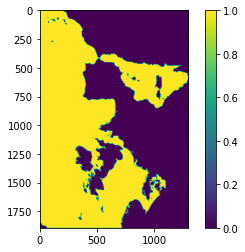

In [141]:
plt.imshow(mask_inp)
plt.colorbar()

In [142]:

# for i in range(len(rnf_2D[:,0,0])):
#     print(i)
rnf_2Dt_new[:,:,:]=move_runoffs(rnf_2Dt[:,:,:].values,rnf_point,mask_inp,True)
# rnf_2Dt_new2[:,:,:]=move_runoffs(rnf_2Dt_new[:,:,:],rnf_point,mask_inp,True) # Has to be iterated twice 

11063
treating runoff point  14 213 0 / 11063
treating runoff point  14 214 1 / 11063
treating runoff point  14 215 2 / 11063
treating runoff point  14 216 3 / 11063
treating runoff point  14 217 4 / 11063
treating runoff point  15 217 5 / 11063
treating runoff point  16 217 6 / 11063
treating runoff point  17 218 7 / 11063
treating runoff point  17 219 8 / 11063
treating runoff point  17 220 9 / 11063
treating runoff point  17 221 10 / 11063
treating runoff point  17 222 11 / 11063
treating runoff point  17 223 12 / 11063
treating runoff point  18 223 13 / 11063
treating runoff point  19 223 14 / 11063
treating runoff point  20 224 15 / 11063
treating runoff point  20 225 16 / 11063
treating runoff point  20 226 17 / 11063
treating runoff point  21 226 18 / 11063
treating runoff point  22 226 19 / 11063
treating runoff point  23 227 20 / 11063
treating runoff point  23 228 21 / 11063
treating runoff point  23 229 22 / 11063
treating runoff point  24 229 23 / 11063
treating runoff poin

treating runoff point  171 369 220 / 11063
treating runoff point  172 369 221 / 11063
treating runoff point  173 369 222 / 11063
treating runoff point  174 369 223 / 11063
treating runoff point  175 369 224 / 11063
treating runoff point  176 369 225 / 11063
treating runoff point  177 368 226 / 11063
treating runoff point  178 368 227 / 11063
treating runoff point  179 368 228 / 11063
treating runoff point  180 367 229 / 11063
treating runoff point  181 366 230 / 11063
treating runoff point  182 365 231 / 11063
treating runoff point  183 364 232 / 11063
treating runoff point  184 361 233 / 11063
treating runoff point  184 362 234 / 11063
treating runoff point  184 363 235 / 11063
treating runoff point  185 360 236 / 11063
treating runoff point  186 360 237 / 11063
treating runoff point  187 360 238 / 11063
treating runoff point  188 361 239 / 11063
treating runoff point  189 361 240 / 11063
treating runoff point  190 362 241 / 11063
treating runoff point  191 362 242 / 11063
treating ru

treating runoff point  365 487 445 / 11063
==> j, i =  365 487 is on mask point
moving point over  1 points : i,j  1 / 1 : = 365 486
treating runoff point  366 487 446 / 11063
==> j, i =  366 487 is on mask point
moving point over  1 points : i,j  1 / 1 : = 366 486
treating runoff point  367 487 447 / 11063
treating runoff point  368 488 448 / 11063
treating runoff point  369 488 449 / 11063
treating runoff point  370 488 450 / 11063
treating runoff point  371 489 451 / 11063
==> j, i =  371 489 is on mask point
moving point over  1 points : i,j  1 / 1 : = 371 488
treating runoff point  372 489 452 / 11063
treating runoff point  373 490 453 / 11063
==> j, i =  373 490 is on mask point
moving point over  1 points : i,j  1 / 1 : = 373 489
treating runoff point  374 490 454 / 11063
==> j, i =  374 490 is on mask point
moving point over  1 points : i,j  1 / 1 : = 374 489
treating runoff point  375 490 455 / 11063
treating runoff point  376 490 456 / 11063
treating runoff point  377 491 457

treating runoff point  389 661 593 / 11063
==> j, i =  389 661 is on mask point
moving point over  1 points : i,j  1 / 1 : = 390 661
treating runoff point  390 495 594 / 11063
treating runoff point  390 537 595 / 11063
treating runoff point  390 605 596 / 11063
==> j, i =  390 605 is on mask point
moving point over  1 points : i,j  1 / 1 : = 390 604
treating runoff point  390 609 597 / 11063
treating runoff point  390 662 598 / 11063
treating runoff point  390 663 599 / 11063
treating runoff point  390 664 600 / 11063
treating runoff point  390 665 601 / 11063
==> j, i =  390 665 is on mask point
moving point over  1 points : i,j  1 / 1 : = 391 665
treating runoff point  391 496 602 / 11063
==> j, i =  391 496 is on mask point
moving point over  1 points : i,j  1 / 1 : = 391 495
treating runoff point  391 536 603 / 11063
treating runoff point  391 605 604 / 11063
treating runoff point  391 609 605 / 11063
treating runoff point  391 666 606 / 11063
==> j, i =  391 666 is on mask point
m

treating runoff point  420 717 703 / 11063
==> j, i =  420 717 is on mask point
moving point over  1 points : i,j  1 / 1 : = 420 716
treating runoff point  421 506 704 / 11063
treating runoff point  421 508 705 / 11063
==> j, i =  421 508 is on mask point
moving point over  2 points : i,j  1 / 2 : = 420 508
moving point over  2 points : i,j  2 / 2 : = 421 507
treating runoff point  421 509 706 / 11063
==> j, i =  421 509 is on mask point
moving point over  1 points : i,j  1 / 1 : = 420 509
treating runoff point  421 510 707 / 11063
==> j, i =  421 510 is on mask point
moving point over  1 points : i,j  1 / 1 : = 420 510
treating runoff point  421 519 708 / 11063
==> j, i =  421 519 is on mask point
moving point over  2 points : i,j  1 / 2 : = 420 519
moving point over  2 points : i,j  2 / 2 : = 421 520
treating runoff point  421 717 709 / 11063
treating runoff point  422 505 710 / 11063
==> j, i =  422 505 is on mask point
moving point over  2 points : i,j  1 / 2 : = 421 505
moving poi

treating runoff point  440 535 793 / 11063
==> j, i =  440 535 is on mask point
moving point over  1 points : i,j  1 / 1 : = 439 535
treating runoff point  440 536 794 / 11063
treating runoff point  440 543 795 / 11063
treating runoff point  440 544 796 / 11063
treating runoff point  440 743 797 / 11063
treating runoff point  440 745 798 / 11063
treating runoff point  441 487 799 / 11063
treating runoff point  441 488 800 / 11063
==> j, i =  441 488 is on mask point
moving point over  2 points : i,j  1 / 2 : = 440 488
moving point over  2 points : i,j  2 / 2 : = 441 487
treating runoff point  441 537 801 / 11063
treating runoff point  441 538 802 / 11063
treating runoff point  441 539 803 / 11063
treating runoff point  441 540 804 / 11063
treating runoff point  441 541 805 / 11063
==> j, i =  441 541 is on mask point
moving point over  1 points : i,j  1 / 1 : = 440 541
treating runoff point  441 542 806 / 11063
==> j, i =  441 542 is on mask point
moving point over  1 points : i,j  1 /

treating runoff point  451 803 905 / 11063
treating runoff point  451 804 906 / 11063
treating runoff point  451 805 907 / 11063
treating runoff point  452 483 908 / 11063
==> j, i =  452 483 is on mask point
moving point over  2 points : i,j  1 / 2 : = 452 482
moving point over  2 points : i,j  2 / 2 : = 453 483
treating runoff point  452 565 909 / 11063
==> j, i =  452 565 is on mask point
moving point over  1 points : i,j  1 / 1 : = 451 565
treating runoff point  452 566 910 / 11063
==> j, i =  452 566 is on mask point
moving point over  2 points : i,j  1 / 2 : = 451 566
moving point over  2 points : i,j  2 / 2 : = 452 567
treating runoff point  452 570 911 / 11063
treating runoff point  452 571 912 / 11063
treating runoff point  452 572 913 / 11063
treating runoff point  452 578 914 / 11063
treating runoff point  452 579 915 / 11063
==> j, i =  452 579 is on mask point
moving point over  1 points : i,j  1 / 1 : = 451 579
treating runoff point  452 580 916 / 11063
==> j, i =  452 58

treating runoff point  459 828 1028 / 11063
==> j, i =  459 828 is on mask point
moving point over  1 points : i,j  1 / 1 : = 460 828
treating runoff point  459 896 1029 / 11063
==> j, i =  459 896 is on mask point
moving point over  1 points : i,j  1 / 1 : = 459 897
treating runoff point  459 912 1030 / 11063
treating runoff point  460 429 1031 / 11063
treating runoff point  460 481 1032 / 11063
==> j, i =  460 481 is on mask point
moving point over  1 points : i,j  1 / 1 : = 460 480
treating runoff point  460 817 1033 / 11063
==> j, i =  460 817 is on mask point
moving point over  2 points : i,j  1 / 2 : = 460 816
moving point over  2 points : i,j  2 / 2 : = 461 817
treating runoff point  460 824 1034 / 11063
treating runoff point  460 829 1035 / 11063
==> j, i =  460 829 is on mask point
moving point over  1 points : i,j  1 / 1 : = 460 828
treating runoff point  460 836 1036 / 11063
==> j, i =  460 836 is on mask point
moving point over  1 points : i,j  1 / 1 : = 461 836
treating ru

treating runoff point  466 848 1152 / 11063
treating runoff point  466 849 1153 / 11063
==> j, i =  466 849 is on mask point
moving point over  1 points : i,j  1 / 1 : = 467 849
treating runoff point  466 861 1154 / 11063
==> j, i =  466 861 is on mask point
moving point over  1 points : i,j  1 / 1 : = 467 861
treating runoff point  466 878 1155 / 11063
==> j, i =  466 878 is on mask point
moving point over  1 points : i,j  1 / 1 : = 467 878
treating runoff point  466 879 1156 / 11063
==> j, i =  466 879 is on mask point
moving point over  1 points : i,j  1 / 1 : = 467 879
treating runoff point  466 886 1157 / 11063
==> j, i =  466 886 is on mask point
moving point over  1 points : i,j  1 / 1 : = 467 886
treating runoff point  466 887 1158 / 11063
treating runoff point  466 888 1159 / 11063
treating runoff point  466 929 1160 / 11063
treating runoff point  466 930 1161 / 11063
==> j, i =  466 930 is on mask point
moving point over  1 points : i,j  1 / 1 : = 467 930
treating runoff poin

treating runoff point  472 956 1302 / 11063
treating runoff point  472 957 1303 / 11063
treating runoff point  472 958 1304 / 11063
treating runoff point  472 959 1305 / 11063
treating runoff point  472 972 1306 / 11063
==> j, i =  472 972 is on mask point
moving point over  2 points : i,j  1 / 2 : = 472 971
moving point over  2 points : i,j  2 / 2 : = 473 972
treating runoff point  472 993 1307 / 11063
treating runoff point  472 1006 1308 / 11063
treating runoff point  472 1007 1309 / 11063
==> j, i =  472 1007 is on mask point
moving point over  1 points : i,j  1 / 1 : = 473 1007
treating runoff point  472 1010 1310 / 11063
treating runoff point  472 1011 1311 / 11063
treating runoff point  472 1012 1312 / 11063
treating runoff point  472 1013 1313 / 11063
treating runoff point  472 1014 1314 / 11063
treating runoff point  472 1015 1315 / 11063
treating runoff point  472 1020 1316 / 11063
treating runoff point  472 1085 1317 / 11063
treating runoff point  472 1094 1318 / 11063
treati

treating runoff point  486 1210 1425 / 11063
treating runoff point  486 1215 1426 / 11063
treating runoff point  486 1216 1427 / 11063
treating runoff point  486 1217 1428 / 11063
treating runoff point  486 1218 1429 / 11063
treating runoff point  486 1219 1430 / 11063
treating runoff point  486 1220 1431 / 11063
treating runoff point  487 397 1432 / 11063
treating runoff point  487 660 1433 / 11063
treating runoff point  487 1042 1434 / 11063
treating runoff point  487 1045 1435 / 11063
treating runoff point  487 1046 1436 / 11063
==> j, i =  487 1046 is on mask point
moving point over  1 points : i,j  1 / 1 : = 488 1046
treating runoff point  487 1079 1437 / 11063
treating runoff point  487 1080 1438 / 11063
treating runoff point  487 1081 1439 / 11063
treating runoff point  487 1082 1440 / 11063
treating runoff point  487 1207 1441 / 11063
treating runoff point  487 1208 1442 / 11063
treating runoff point  487 1209 1443 / 11063
treating runoff point  487 1210 1444 / 11063
treating r

treating runoff point  502 1033 1560 / 11063
treating runoff point  502 1034 1561 / 11063
treating runoff point  502 1187 1562 / 11063
treating runoff point  503 396 1563 / 11063
treating runoff point  503 686 1564 / 11063
treating runoff point  503 1186 1565 / 11063
treating runoff point  504 395 1566 / 11063
treating runoff point  504 396 1567 / 11063
==> j, i =  504 396 is on mask point
moving point over  2 points : i,j  1 / 2 : = 503 396
moving point over  2 points : i,j  2 / 2 : = 504 395
treating runoff point  504 1180 1568 / 11063
treating runoff point  504 1181 1569 / 11063
treating runoff point  504 1182 1570 / 11063
treating runoff point  504 1183 1571 / 11063
treating runoff point  504 1184 1572 / 11063
treating runoff point  504 1185 1573 / 11063
treating runoff point  505 394 1574 / 11063
==> j, i =  505 394 is on mask point
moving point over  2 points : i,j  1 / 2 : = 504 394
moving point over  2 points : i,j  2 / 2 : = 505 393
treating runoff point  505 686 1575 / 11063


treating runoff point  529 1207 1705 / 11063
treating runoff point  530 382 1706 / 11063
treating runoff point  530 392 1707 / 11063
==> j, i =  530 392 is on mask point
moving point over  1 points : i,j  1 / 1 : = 529 391
treating runoff point  530 695 1708 / 11063
==> j, i =  530 695 is on mask point
moving point over  1 points : i,j  1 / 1 : = 529 695
treating runoff point  530 696 1709 / 11063
treating runoff point  530 697 1710 / 11063
==> j, i =  530 697 is on mask point
moving point over  2 points : i,j  1 / 2 : = 529 697
moving point over  2 points : i,j  2 / 2 : = 530 698
treating runoff point  530 1161 1711 / 11063
treating runoff point  530 1203 1712 / 11063
treating runoff point  530 1204 1713 / 11063
treating runoff point  530 1208 1714 / 11063
treating runoff point  530 1209 1715 / 11063
treating runoff point  531 382 1716 / 11063
treating runoff point  531 698 1717 / 11063
treating runoff point  531 1162 1718 / 11063
treating runoff point  531 1174 1719 / 11063
treating 

treating runoff point  540 1244 1845 / 11063
treating runoff point  540 1249 1846 / 11063
treating runoff point  540 1250 1847 / 11063
treating runoff point  540 1251 1848 / 11063
treating runoff point  540 1252 1849 / 11063
treating runoff point  540 1256 1850 / 11063
treating runoff point  541 372 1851 / 11063
==> j, i =  541 372 is on mask point
moving point over  1 points : i,j  1 / 1 : = 541 371
treating runoff point  541 710 1852 / 11063
treating runoff point  541 1189 1853 / 11063
treating runoff point  541 1245 1854 / 11063
treating runoff point  541 1246 1855 / 11063
treating runoff point  541 1248 1856 / 11063
treating runoff point  541 1257 1857 / 11063
treating runoff point  542 371 1858 / 11063
treating runoff point  542 710 1859 / 11063
treating runoff point  542 1247 1860 / 11063
treating runoff point  542 1257 1861 / 11063
treating runoff point  543 371 1862 / 11063
==> j, i =  543 371 is on mask point
moving point over  1 points : i,j  1 / 1 : = 543 370
treating runoff

treating runoff point  570 373 2017 / 11063
treating runoff point  570 704 2018 / 11063
==> j, i =  570 704 is surrounded by sea 
570 704 surrounded by sea points, trying ndist=+1; next radius =  5
0
moving point over  1 points, : i, j = 570 703
treating runoff point  570 1012 2019 / 11063
==> j, i =  570 1012 is on mask point
moving point over  2 points : i,j  1 / 2 : = 569 1012
moving point over  2 points : i,j  2 / 2 : = 570 1011
treating runoff point  570 1014 2020 / 11063
treating runoff point  570 1019 2021 / 11063
==> j, i =  570 1019 is on mask point
moving point over  1 points : i,j  1 / 1 : = 570 1018
treating runoff point  570 1032 2022 / 11063
==> j, i =  570 1032 is on mask point
moving point over  2 points : i,j  1 / 2 : = 569 1032
moving point over  2 points : i,j  2 / 2 : = 570 1033
treating runoff point  570 1284 2023 / 11063
treating runoff point  570 1288 2024 / 11063
treating runoff point  570 1289 2025 / 11063
treating runoff point  571 374 2026 / 11063
treating ru

treating runoff point  582 813 2119 / 11063
==> j, i =  582 813 is on mask point
moving point over  1 points : i,j  1 / 1 : = 581 813
treating runoff point  582 814 2120 / 11063
==> j, i =  582 814 is on mask point
moving point over  1 points : i,j  1 / 1 : = 581 814
treating runoff point  582 815 2121 / 11063
==> j, i =  582 815 is on mask point
moving point over  1 points : i,j  1 / 1 : = 581 815
treating runoff point  582 816 2122 / 11063
==> j, i =  582 816 is on mask point
moving point over  1 points : i,j  1 / 1 : = 581 816
treating runoff point  582 1010 2123 / 11063
treating runoff point  582 1036 2124 / 11063
treating runoff point  582 1038 2125 / 11063
==> j, i =  582 1038 is on mask point
moving point over  2 points : i,j  1 / 2 : = 581 1038
moving point over  2 points : i,j  2 / 2 : = 582 1037
treating runoff point  582 1039 2126 / 11063
==> j, i =  582 1039 is on mask point
moving point over  2 points : i,j  1 / 2 : = 581 1039
moving point over  2 points : i,j  2 / 2 : = 5

treating runoff point  591 1286 2210 / 11063
treating runoff point  592 388 2211 / 11063
==> j, i =  592 388 is on mask point
moving point over  1 points : i,j  1 / 1 : = 592 387
treating runoff point  592 703 2212 / 11063
treating runoff point  592 792 2213 / 11063
treating runoff point  592 1010 2214 / 11063
treating runoff point  592 1055 2215 / 11063
treating runoff point  592 1286 2216 / 11063
treating runoff point  593 388 2217 / 11063
==> j, i =  593 388 is on mask point
moving point over  1 points : i,j  1 / 1 : = 593 387
treating runoff point  593 703 2218 / 11063
==> j, i =  593 703 is on mask point
moving point over  1 points : i,j  1 / 1 : = 593 704
treating runoff point  593 793 2219 / 11063
==> j, i =  593 793 is on mask point
moving point over  2 points : i,j  1 / 2 : = 593 792
moving point over  2 points : i,j  2 / 2 : = 594 793
treating runoff point  593 1010 2220 / 11063
treating runoff point  593 1055 2221 / 11063
treating runoff point  593 1286 2222 / 11063
treating

treating runoff point  610 1281 2330 / 11063
treating runoff point  611 391 2331 / 11063
treating runoff point  611 1015 2332 / 11063
==> j, i =  611 1015 is on mask point
moving point over  1 points : i,j  1 / 1 : = 611 1014
treating runoff point  611 1057 2333 / 11063
treating runoff point  611 1279 2334 / 11063
treating runoff point  611 1280 2335 / 11063
treating runoff point  612 391 2336 / 11063
treating runoff point  612 1015 2337 / 11063
treating runoff point  612 1057 2338 / 11063
treating runoff point  612 1278 2339 / 11063
treating runoff point  613 392 2340 / 11063
==> j, i =  613 392 is on mask point
moving point over  1 points : i,j  1 / 1 : = 613 391
treating runoff point  613 1015 2341 / 11063
treating runoff point  613 1056 2342 / 11063
==> j, i =  613 1056 is on mask point
moving point over  1 points : i,j  1 / 1 : = 613 1057
treating runoff point  613 1278 2343 / 11063
treating runoff point  614 392 2344 / 11063
treating runoff point  614 1015 2345 / 11063
treating r

treating runoff point  641 398 2476 / 11063
==> j, i =  641 398 is on mask point
moving point over  1 points : i,j  1 / 1 : = 641 397
treating runoff point  641 1008 2477 / 11063
treating runoff point  641 1056 2478 / 11063
treating runoff point  641 1252 2479 / 11063
treating runoff point  642 398 2480 / 11063
==> j, i =  642 398 is on mask point
moving point over  1 points : i,j  1 / 1 : = 642 397
treating runoff point  642 1009 2481 / 11063
==> j, i =  642 1009 is on mask point
moving point over  1 points : i,j  1 / 1 : = 642 1008
treating runoff point  642 1056 2482 / 11063
==> j, i =  642 1056 is on mask point
moving point over  1 points : i,j  1 / 1 : = 642 1057
treating runoff point  642 1248 2483 / 11063
treating runoff point  642 1249 2484 / 11063
treating runoff point  642 1251 2485 / 11063
treating runoff point  643 398 2486 / 11063
treating runoff point  643 1009 2487 / 11063
==> j, i =  643 1009 is on mask point
moving point over  1 points : i,j  1 / 1 : = 643 1008
treatin

treating runoff point  664 1010 2595 / 11063
treating runoff point  664 1011 2596 / 11063
treating runoff point  664 1012 2597 / 11063
treating runoff point  664 1013 2598 / 11063
treating runoff point  664 1055 2599 / 11063
treating runoff point  664 1220 2600 / 11063
treating runoff point  664 1224 2601 / 11063
treating runoff point  664 1225 2602 / 11063
treating runoff point  664 1228 2603 / 11063
treating runoff point  664 1229 2604 / 11063
treating runoff point  664 1240 2605 / 11063
treating runoff point  665 394 2606 / 11063
treating runoff point  665 1001 2607 / 11063
treating runoff point  665 1005 2608 / 11063
==> j, i =  665 1005 is on mask point
moving point over  1 points : i,j  1 / 1 : = 666 1005
treating runoff point  665 1006 2609 / 11063
treating runoff point  665 1007 2610 / 11063
treating runoff point  665 1008 2611 / 11063
treating runoff point  665 1009 2612 / 11063
treating runoff point  665 1014 2613 / 11063
treating runoff point  665 1015 2614 / 11063
==> j, i 

treating runoff point  674 1221 2733 / 11063
treating runoff point  675 393 2734 / 11063
==> j, i =  675 393 is on mask point
moving point over  1 points : i,j  1 / 1 : = 675 392
treating runoff point  675 782 2735 / 11063
==> j, i =  675 782 is on mask point
moving point over  2 points : i,j  1 / 2 : = 674 782
moving point over  2 points : i,j  2 / 2 : = 675 783
treating runoff point  675 1006 2736 / 11063
treating runoff point  675 1054 2737 / 11063
treating runoff point  675 1171 2738 / 11063
treating runoff point  675 1210 2739 / 11063
treating runoff point  675 1217 2740 / 11063
treating runoff point  675 1220 2741 / 11063
treating runoff point  676 392 2742 / 11063
treating runoff point  676 783 2743 / 11063
==> j, i =  676 783 is on mask point
moving point over  1 points : i,j  1 / 1 : = 675 783
treating runoff point  676 784 2744 / 11063
treating runoff point  676 1002 2745 / 11063
treating runoff point  676 1006 2746 / 11063
treating runoff point  676 1025 2747 / 11063
treatin

==> j, i =  690 1043 is surrounded by sea 
690 1043 surrounded by sea points, trying ndist=+1; next radius =  5
0
moving point over  1 points, : i, j = 690 1042
treating runoff point  690 1203 2875 / 11063
treating runoff point  691 389 2876 / 11063
treating runoff point  691 799 2877 / 11063
==> j, i =  691 799 is on mask point
moving point over  1 points : i,j  1 / 1 : = 690 799
treating runoff point  691 800 2878 / 11063
treating runoff point  691 1041 2879 / 11063
treating runoff point  691 1042 2880 / 11063
treating runoff point  691 1202 2881 / 11063
treating runoff point  692 389 2882 / 11063
treating runoff point  692 801 2883 / 11063
==> j, i =  692 801 is on mask point
moving point over  1 points : i,j  1 / 1 : = 691 801
treating runoff point  692 802 2884 / 11063
treating runoff point  692 1035 2885 / 11063
treating runoff point  692 1038 2886 / 11063
==> j, i =  692 1038 is on mask point
moving point over  3 points : i,j  1 / 3 : = 691 1038
moving point over  3 points : i,j

treating runoff point  703 1165 2985 / 11063
treating runoff point  703 1166 2986 / 11063
treating runoff point  703 1167 2987 / 11063
treating runoff point  704 391 2988 / 11063
treating runoff point  704 816 2989 / 11063
==> j, i =  704 816 is on mask point
moving point over  1 points : i,j  1 / 1 : = 704 817
treating runoff point  704 1019 2990 / 11063
treating runoff point  704 1041 2991 / 11063
treating runoff point  704 1158 2992 / 11063
treating runoff point  704 1161 2993 / 11063
treating runoff point  705 391 2994 / 11063
treating runoff point  705 817 2995 / 11063
==> j, i =  705 817 is on mask point
moving point over  1 points : i,j  1 / 1 : = 704 817
treating runoff point  705 818 2996 / 11063
==> j, i =  705 818 is on mask point
moving point over  2 points : i,j  1 / 2 : = 704 818
moving point over  2 points : i,j  2 / 2 : = 705 819
treating runoff point  705 1020 2997 / 11063
==> j, i =  705 1020 is on mask point
moving point over  1 points : i,j  1 / 1 : = 705 1019
treat

moving point over  2 points : i,j  2 / 2 : = 720 385
treating runoff point  720 389 3100 / 11063
treating runoff point  720 390 3101 / 11063
treating runoff point  720 817 3102 / 11063
==> j, i =  720 817 is on mask point
moving point over  2 points : i,j  1 / 2 : = 720 818
moving point over  2 points : i,j  2 / 2 : = 721 817
treating runoff point  720 818 3103 / 11063
treating runoff point  720 1013 3104 / 11063
==> j, i =  720 1013 is on mask point
moving point over  2 points : i,j  1 / 2 : = 719 1013
moving point over  2 points : i,j  2 / 2 : = 720 1012
treating runoff point  720 1017 3105 / 11063
==> j, i =  720 1017 is on mask point
moving point over  1 points : i,j  1 / 1 : = 719 1017
treating runoff point  720 1018 3106 / 11063
treating runoff point  720 1019 3107 / 11063
treating runoff point  720 1042 3108 / 11063
treating runoff point  720 1142 3109 / 11063
treating runoff point  721 383 3110 / 11063
==> j, i =  721 383 is on mask point
moving point over  1 points : i,j  1 / 

treating runoff point  734 1130 3217 / 11063
treating runoff point  734 1131 3218 / 11063
treating runoff point  735 380 3219 / 11063
==> j, i =  735 380 is on mask point
moving point over  1 points : i,j  1 / 1 : = 735 379
treating runoff point  735 818 3220 / 11063
treating runoff point  735 1010 3221 / 11063
treating runoff point  735 1047 3222 / 11063
treating runoff point  735 1127 3223 / 11063
treating runoff point  736 378 3224 / 11063
treating runoff point  736 818 3225 / 11063
treating runoff point  736 1010 3226 / 11063
==> j, i =  736 1010 is on mask point
moving point over  2 points : i,j  1 / 2 : = 736 1009
moving point over  2 points : i,j  2 / 2 : = 737 1010
treating runoff point  736 1047 3227 / 11063
treating runoff point  736 1126 3228 / 11063
treating runoff point  737 374 3229 / 11063
treating runoff point  737 377 3230 / 11063
==> j, i =  737 377 is surrounded by sea 
737 377 surrounded by sea points, trying ndist=+1; next radius =  5
0
moving point over  1 points,

treating runoff point  753 1014 3355 / 11063
treating runoff point  753 1045 3356 / 11063
treating runoff point  753 1099 3357 / 11063
treating runoff point  753 1105 3358 / 11063
treating runoff point  753 1106 3359 / 11063
treating runoff point  754 813 3360 / 11063
treating runoff point  754 1014 3361 / 11063
treating runoff point  754 1045 3362 / 11063
treating runoff point  754 1099 3363 / 11063
treating runoff point  755 813 3364 / 11063
treating runoff point  755 1014 3365 / 11063
treating runoff point  755 1016 3366 / 11063
treating runoff point  755 1017 3367 / 11063
treating runoff point  755 1045 3368 / 11063
treating runoff point  755 1100 3369 / 11063
treating runoff point  755 1101 3370 / 11063
treating runoff point  755 1102 3371 / 11063
treating runoff point  755 1103 3372 / 11063
treating runoff point  756 813 3373 / 11063
treating runoff point  756 1015 3374 / 11063
treating runoff point  756 1017 3375 / 11063
treating runoff point  756 1044 3376 / 11063
==> j, i =  7

moving point over  1 points : i,j  1 / 1 : = 770 625
treating runoff point  769 626 3496 / 11063
treating runoff point  769 627 3497 / 11063
treating runoff point  769 814 3498 / 11063
==> j, i =  769 814 is on mask point
moving point over  1 points : i,j  1 / 1 : = 769 815
treating runoff point  769 1036 3499 / 11063
==> j, i =  769 1036 is on mask point
moving point over  1 points : i,j  1 / 1 : = 769 1035
treating runoff point  769 1042 3500 / 11063
treating runoff point  769 1063 3501 / 11063
treating runoff point  769 1075 3502 / 11063
treating runoff point  769 1094 3503 / 11063
treating runoff point  770 406 3504 / 11063
treating runoff point  770 538 3505 / 11063
treating runoff point  770 539 3506 / 11063
treating runoff point  770 540 3507 / 11063
treating runoff point  770 541 3508 / 11063
==> j, i =  770 541 is on mask point
moving point over  1 points : i,j  1 / 1 : = 771 541
treating runoff point  770 542 3509 / 11063
==> j, i =  770 542 is on mask point
moving point over

treating runoff point  774 452 3639 / 11063
treating runoff point  774 454 3640 / 11063
==> j, i =  774 454 is on mask point
moving point over  1 points : i,j  1 / 1 : = 775 454
treating runoff point  774 516 3641 / 11063
treating runoff point  774 520 3642 / 11063
treating runoff point  774 560 3643 / 11063
treating runoff point  774 561 3644 / 11063
treating runoff point  774 581 3645 / 11063
treating runoff point  774 597 3646 / 11063
treating runoff point  774 607 3647 / 11063
treating runoff point  774 608 3648 / 11063
==> j, i =  774 608 is on mask point
moving point over  1 points : i,j  1 / 1 : = 775 608
treating runoff point  774 609 3649 / 11063
treating runoff point  774 610 3650 / 11063
treating runoff point  774 637 3651 / 11063
treating runoff point  774 640 3652 / 11063
==> j, i =  774 640 is on mask point
moving point over  1 points : i,j  1 / 1 : = 775 640
treating runoff point  774 817 3653 / 11063
==> j, i =  774 817 is on mask point
moving point over  1 points : i,j

moving point over  2 points : i,j  2 / 2 : = 777 905
treating runoff point  777 907 3783 / 11063
==> j, i =  777 907 is on mask point
moving point over  1 points : i,j  1 / 1 : = 776 907
treating runoff point  777 908 3784 / 11063
==> j, i =  777 908 is on mask point
moving point over  1 points : i,j  1 / 1 : = 776 908
treating runoff point  777 924 3785 / 11063
==> j, i =  777 924 is on mask point
moving point over  1 points : i,j  1 / 1 : = 776 924
treating runoff point  777 925 3786 / 11063
==> j, i =  777 925 is on mask point
moving point over  1 points : i,j  1 / 1 : = 776 925
treating runoff point  777 926 3787 / 11063
==> j, i =  777 926 is on mask point
moving point over  1 points : i,j  1 / 1 : = 776 926
treating runoff point  777 927 3788 / 11063
==> j, i =  777 927 is on mask point
moving point over  1 points : i,j  1 / 1 : = 776 927
treating runoff point  777 930 3789 / 11063
treating runoff point  777 1035 3790 / 11063
treating runoff point  777 1041 3791 / 11063
treating 

treating runoff point  782 420 3884 / 11063
==> j, i =  782 420 is on mask point
moving point over  2 points : i,j  1 / 2 : = 782 419
moving point over  2 points : i,j  2 / 2 : = 783 420
treating runoff point  782 423 3885 / 11063
==> j, i =  782 423 is on mask point
moving point over  1 points : i,j  1 / 1 : = 782 424
treating runoff point  782 425 3886 / 11063
treating runoff point  782 426 3887 / 11063
treating runoff point  782 431 3888 / 11063
treating runoff point  782 434 3889 / 11063
treating runoff point  782 435 3890 / 11063
treating runoff point  782 436 3891 / 11063
treating runoff point  782 648 3892 / 11063
==> j, i =  782 648 is on mask point
moving point over  1 points : i,j  1 / 1 : = 782 647
treating runoff point  782 649 3893 / 11063
==> j, i =  782 649 is on mask point
moving point over  1 points : i,j  1 / 1 : = 783 648
treating runoff point  782 650 3894 / 11063
==> j, i =  782 650 is on mask point
782 650 surrounded by earth points, trying ndist=+1; next radius =

treating runoff point  790 854 3989 / 11063
==> j, i =  790 854 is on mask point
moving point over  1 points : i,j  1 / 1 : = 789 854
treating runoff point  790 855 3990 / 11063
==> j, i =  790 855 is on mask point
moving point over  1 points : i,j  1 / 1 : = 789 855
treating runoff point  790 856 3991 / 11063
==> j, i =  790 856 is on mask point
moving point over  1 points : i,j  1 / 1 : = 789 856
treating runoff point  790 857 3992 / 11063
treating runoff point  790 858 3993 / 11063
treating runoff point  790 859 3994 / 11063
==> j, i =  790 859 is on mask point
moving point over  1 points : i,j  1 / 1 : = 789 859
treating runoff point  790 860 3995 / 11063
==> j, i =  790 860 is on mask point
moving point over  1 points : i,j  1 / 1 : = 789 860
treating runoff point  790 861 3996 / 11063
treating runoff point  790 862 3997 / 11063
treating runoff point  790 863 3998 / 11063
treating runoff point  790 864 3999 / 11063
==> j, i =  790 864 is on mask point
moving point over  1 points :

treating runoff point  804 652 4074 / 11063
treating runoff point  804 956 4075 / 11063
treating runoff point  804 1053 4076 / 11063
treating runoff point  804 1055 4077 / 11063
treating runoff point  804 1072 4078 / 11063
treating runoff point  805 652 4079 / 11063
treating runoff point  805 956 4080 / 11063
treating runoff point  805 1054 4081 / 11063
treating runoff point  805 1071 4082 / 11063
treating runoff point  806 652 4083 / 11063
treating runoff point  806 956 4084 / 11063
treating runoff point  806 1070 4085 / 11063
treating runoff point  806 1071 4086 / 11063
treating runoff point  807 652 4087 / 11063
treating runoff point  807 956 4088 / 11063
treating runoff point  807 958 4089 / 11063
treating runoff point  807 1069 4090 / 11063
treating runoff point  808 653 4091 / 11063
==> j, i =  808 653 is on mask point
moving point over  1 points : i,j  1 / 1 : = 808 652
treating runoff point  808 957 4092 / 11063
==> j, i =  808 957 is on mask point
moving point over  1 points :

treating runoff point  849 654 4224 / 11063
treating runoff point  849 1025 4225 / 11063
==> j, i =  849 1025 is on mask point
moving point over  2 points : i,j  1 / 2 : = 848 1025
moving point over  2 points : i,j  2 / 2 : = 849 1024
treating runoff point  849 1027 4226 / 11063
treating runoff point  849 1031 4227 / 11063
==> j, i =  849 1031 is on mask point
moving point over  2 points : i,j  1 / 2 : = 848 1031
moving point over  2 points : i,j  2 / 2 : = 849 1030
treating runoff point  849 1032 4228 / 11063
==> j, i =  849 1032 is on mask point
moving point over  1 points : i,j  1 / 1 : = 848 1032
treating runoff point  850 654 4229 / 11063
treating runoff point  850 1027 4230 / 11063
treating runoff point  850 1028 4231 / 11063
treating runoff point  850 1029 4232 / 11063
==> j, i =  850 1029 is on mask point
moving point over  1 points : i,j  1 / 1 : = 849 1029
treating runoff point  850 1030 4233 / 11063
==> j, i =  850 1030 is on mask point
moving point over  1 points : i,j  1 /

moving point over  2 points : i,j  1 / 2 : = 886 662
moving point over  2 points : i,j  2 / 2 : = 887 661
treating runoff point  887 663 4312 / 11063
==> j, i =  887 663 is on mask point
moving point over  1 points : i,j  1 / 1 : = 886 663
treating runoff point  888 658 4313 / 11063
==> j, i =  888 658 is on mask point
moving point over  3 points : i,j  1 / 3 : = 888 657
moving point over  3 points : i,j  2 / 3 : = 888 659
moving point over  3 points : i,j  3 / 3 : = 889 658
treating runoff point  888 661 4314 / 11063
==> j, i =  888 661 is on mask point
moving point over  2 points : i,j  1 / 2 : = 887 661
moving point over  2 points : i,j  2 / 2 : = 888 660
treating runoff point  889 660 4315 / 11063
==> j, i =  889 660 is on mask point
moving point over  2 points : i,j  1 / 2 : = 888 660
moving point over  2 points : i,j  2 / 2 : = 889 659
treating runoff point  890 658 4316 / 11063
treating runoff point  890 659 4317 / 11063
==> j, i =  890 659 is on mask point
moving point over  1 

treating runoff point  927 652 4405 / 11063
==> j, i =  927 652 is on mask point
moving point over  1 points : i,j  1 / 1 : = 926 653
treating runoff point  927 653 4406 / 11063
==> j, i =  927 653 is on mask point
moving point over  1 points : i,j  1 / 1 : = 926 653
treating runoff point  928 640 4407 / 11063
treating runoff point  929 640 4408 / 11063
treating runoff point  930 635 4409 / 11063
treating runoff point  930 636 4410 / 11063
treating runoff point  930 637 4411 / 11063
treating runoff point  930 638 4412 / 11063
treating runoff point  930 639 4413 / 11063
treating runoff point  931 633 4414 / 11063
treating runoff point  931 634 4415 / 11063
treating runoff point  932 632 4416 / 11063
treating runoff point  933 631 4417 / 11063
==> j, i =  933 631 is on mask point
moving point over  2 points : i,j  1 / 2 : = 932 631
moving point over  2 points : i,j  2 / 2 : = 933 630
treating runoff point  934 629 4418 / 11063
==> j, i =  934 629 is on mask point
moving point over  2 poi

treating runoff point  985 594 4529 / 11063
==> j, i =  985 594 is on mask point
moving point over  1 points : i,j  1 / 1 : = 984 594
treating runoff point  985 600 4530 / 11063
treating runoff point  986 577 4531 / 11063
treating runoff point  986 579 4532 / 11063
treating runoff point  986 586 4533 / 11063
treating runoff point  986 587 4534 / 11063
==> j, i =  986 587 is on mask point
moving point over  1 points : i,j  1 / 1 : = 985 587
treating runoff point  986 595 4535 / 11063
==> j, i =  986 595 is on mask point
moving point over  1 points : i,j  1 / 1 : = 985 596
treating runoff point  986 596 4536 / 11063
==> j, i =  986 596 is on mask point
moving point over  1 points : i,j  1 / 1 : = 985 596
treating runoff point  986 597 4537 / 11063
==> j, i =  986 597 is on mask point
moving point over  1 points : i,j  1 / 1 : = 985 597
treating runoff point  986 598 4538 / 11063
treating runoff point  986 599 4539 / 11063
==> j, i =  986 599 is on mask point
moving point over  2 points :

treating runoff point  1022 524 4656 / 11063
==> j, i =  1022 524 is on mask point
moving point over  1 points : i,j  1 / 1 : = 1023 524
treating runoff point  1023 518 4657 / 11063
treating runoff point  1023 519 4658 / 11063
treating runoff point  1023 520 4659 / 11063
treating runoff point  1023 525 4660 / 11063
==> j, i =  1023 525 is on mask point
moving point over  1 points : i,j  1 / 1 : = 1023 524
treating runoff point  1023 527 4661 / 11063
==> j, i =  1023 527 is on mask point
moving point over  2 points : i,j  1 / 2 : = 1023 528
moving point over  2 points : i,j  2 / 2 : = 1024 527
treating runoff point  1023 528 4662 / 11063
treating runoff point  1023 529 4663 / 11063
==> j, i =  1023 529 is on mask point
moving point over  1 points : i,j  1 / 1 : = 1024 529
treating runoff point  1023 530 4664 / 11063
==> j, i =  1023 530 is on mask point
moving point over  2 points : i,j  1 / 2 : = 1023 531
moving point over  2 points : i,j  2 / 2 : = 1024 530
treating runoff point  1023

treating runoff point  1047 555 4754 / 11063
treating runoff point  1047 557 4755 / 11063
treating runoff point  1047 585 4756 / 11063
treating runoff point  1047 596 4757 / 11063
==> j, i =  1047 596 is on mask point
moving point over  2 points : i,j  1 / 2 : = 1047 595
moving point over  2 points : i,j  2 / 2 : = 1048 596
treating runoff point  1047 607 4758 / 11063
treating runoff point  1048 541 4759 / 11063
treating runoff point  1048 544 4760 / 11063
treating runoff point  1048 550 4761 / 11063
treating runoff point  1048 557 4762 / 11063
treating runoff point  1048 583 4763 / 11063
==> j, i =  1048 583 is on mask point
moving point over  2 points : i,j  1 / 2 : = 1048 584
moving point over  2 points : i,j  2 / 2 : = 1049 583
treating runoff point  1048 584 4764 / 11063
treating runoff point  1048 597 4765 / 11063
treating runoff point  1048 598 4766 / 11063
==> j, i =  1048 598 is on mask point
moving point over  1 points : i,j  1 / 1 : = 1049 598
treating runoff point  1048 599

treating runoff point  1057 568 4842 / 11063
treating runoff point  1057 571 4843 / 11063
==> j, i =  1057 571 is on mask point
moving point over  1 points : i,j  1 / 1 : = 1057 572
treating runoff point  1057 572 4844 / 11063
treating runoff point  1057 575 4845 / 11063
treating runoff point  1057 627 4846 / 11063
treating runoff point  1058 569 4847 / 11063
treating runoff point  1058 570 4848 / 11063
treating runoff point  1058 573 4849 / 11063
treating runoff point  1058 574 4850 / 11063
==> j, i =  1058 574 is on mask point
moving point over  1 points : i,j  1 / 1 : = 1059 574
treating runoff point  1058 627 4851 / 11063
==> j, i =  1058 627 is on mask point
moving point over  1 points : i,j  1 / 1 : = 1058 626
treating runoff point  1059 627 4852 / 11063
==> j, i =  1059 627 is on mask point
moving point over  1 points : i,j  1 / 1 : = 1059 626
treating runoff point  1060 626 4853 / 11063
==> j, i =  1060 626 is on mask point
moving point over  2 points : i,j  1 / 2 : = 1059 626


treating runoff point  1112 499 4932 / 11063
treating runoff point  1113 479 4933 / 11063
==> j, i =  1113 479 is on mask point
moving point over  2 points : i,j  1 / 2 : = 1112 479
moving point over  2 points : i,j  2 / 2 : = 1113 478
treating runoff point  1113 481 4934 / 11063
==> j, i =  1113 481 is on mask point
moving point over  1 points : i,j  1 / 1 : = 1112 481
treating runoff point  1113 482 4935 / 11063
treating runoff point  1113 493 4936 / 11063
treating runoff point  1113 500 4937 / 11063
treating runoff point  1114 478 4938 / 11063
==> j, i =  1114 478 is on mask point
moving point over  2 points : i,j  1 / 2 : = 1113 478
moving point over  2 points : i,j  2 / 2 : = 1114 477
treating runoff point  1114 483 4939 / 11063
==> j, i =  1114 483 is on mask point
moving point over  2 points : i,j  1 / 2 : = 1113 483
moving point over  2 points : i,j  2 / 2 : = 1114 484
treating runoff point  1114 493 4940 / 11063
==> j, i =  1114 493 is on mask point
moving point over  1 points

moving point over  1 points : i,j  1 / 1 : = 1131 518
treating runoff point  1132 519 5020 / 11063
treating runoff point  1132 529 5021 / 11063
treating runoff point  1132 532 5022 / 11063
treating runoff point  1132 534 5023 / 11063
==> j, i =  1132 534 is on mask point
moving point over  2 points : i,j  1 / 2 : = 1131 534
moving point over  2 points : i,j  2 / 2 : = 1132 533
treating runoff point  1132 536 5024 / 11063
treating runoff point  1132 537 5025 / 11063
treating runoff point  1132 538 5026 / 11063
==> j, i =  1132 538 is on mask point
moving point over  1 points : i,j  1 / 1 : = 1131 538
treating runoff point  1132 539 5027 / 11063
==> j, i =  1132 539 is on mask point
moving point over  1 points : i,j  1 / 1 : = 1131 539
treating runoff point  1132 549 5028 / 11063
treating runoff point  1133 495 5029 / 11063
treating runoff point  1133 520 5030 / 11063
==> j, i =  1133 520 is on mask point
moving point over  2 points : i,j  1 / 2 : = 1132 520
moving point over  2 points :

treating runoff point  1152 587 5109 / 11063
treating runoff point  1152 590 5110 / 11063
treating runoff point  1152 726 5111 / 11063
treating runoff point  1153 511 5112 / 11063
==> j, i =  1153 511 is on mask point
moving point over  1 points : i,j  1 / 1 : = 1153 510
treating runoff point  1153 559 5113 / 11063
treating runoff point  1153 586 5114 / 11063
==> j, i =  1153 586 is on mask point
moving point over  2 points : i,j  1 / 2 : = 1152 586
moving point over  2 points : i,j  2 / 2 : = 1153 585
treating runoff point  1153 588 5115 / 11063
==> j, i =  1153 588 is on mask point
moving point over  2 points : i,j  1 / 2 : = 1152 587
moving point over  2 points : i,j  2 / 2 : = 1154 589
treating runoff point  1153 590 5116 / 11063
treating runoff point  1153 726 5117 / 11063
treating runoff point  1154 511 5118 / 11063
treating runoff point  1154 559 5119 / 11063
==> j, i =  1154 559 is on mask point
moving point over  1 points : i,j  1 / 1 : = 1154 560
treating runoff point  1154 5

moving point over  1 points : i,j  1 / 1 : = 1163 614
treating runoff point  1164 616 5201 / 11063
==> j, i =  1164 616 is on mask point
1164 616 surrounded by earth points, trying ndist=+1; next radius =  5
moving point over  3 points : i,j  1 / 3 : = 1162 614
moving point over  3 points : i,j  2 / 3 : = 1162 615
moving point over  3 points : i,j  3 / 3 : = 1163 614
treating runoff point  1164 618 5202 / 11063
==> j, i =  1164 618 is on mask point
1164 618 surrounded by earth points, trying ndist=+1; next radius =  5
1164 618 surrounded by earth points, trying ndist=+1; next radius =  7
moving point over  4 points : i,j  1 / 4 : = 1161 615
moving point over  4 points : i,j  2 / 4 : = 1161 616
moving point over  4 points : i,j  3 / 4 : = 1161 620
moving point over  4 points : i,j  4 / 4 : = 1162 615
treating runoff point  1164 726 5203 / 11063
treating runoff point  1165 513 5204 / 11063
treating runoff point  1165 619 5205 / 11063
==> j, i =  1165 619 is on mask point
1165 619 surroun

treating runoff point  1171 515 5250 / 11063
treating runoff point  1171 516 5251 / 11063
treating runoff point  1171 517 5252 / 11063
treating runoff point  1171 518 5253 / 11063
treating runoff point  1171 522 5254 / 11063
==> j, i =  1171 522 is on mask point
moving point over  2 points : i,j  1 / 2 : = 1171 521
moving point over  2 points : i,j  2 / 2 : = 1172 522
treating runoff point  1171 626 5255 / 11063
==> j, i =  1171 626 is on mask point
1171 626 surrounded by earth points, trying ndist=+1; next radius =  5
1171 626 surrounded by earth points, trying ndist=+1; next radius =  7
1171 626 surrounded by earth points, trying ndist=+1; next radius =  9
1171 626 surrounded by earth points, trying ndist=+1; next radius =  11
1171 626 surrounded by earth points, trying ndist=+1; next radius =  13
1171 626 surrounded by earth points, trying ndist=+1; next radius =  15
1171 626 surrounded by earth points, trying ndist=+1; next radius =  17
1171 626 surrounded by earth points, trying n

treating runoff point  1182 330 5344 / 11063
treating runoff point  1182 332 5345 / 11063
treating runoff point  1182 341 5346 / 11063
==> j, i =  1182 341 is on mask point
moving point over  2 points : i,j  1 / 2 : = 1181 341
moving point over  2 points : i,j  2 / 2 : = 1182 342
treating runoff point  1182 352 5347 / 11063
==> j, i =  1182 352 is on mask point
moving point over  2 points : i,j  1 / 2 : = 1181 352
moving point over  2 points : i,j  2 / 2 : = 1182 353
treating runoff point  1182 525 5348 / 11063
treating runoff point  1182 526 5349 / 11063
==> j, i =  1182 526 is on mask point
moving point over  1 points : i,j  1 / 1 : = 1183 526
treating runoff point  1182 725 5350 / 11063
==> j, i =  1182 725 is on mask point
moving point over  1 points : i,j  1 / 1 : = 1182 724
treating runoff point  1183 329 5351 / 11063
treating runoff point  1183 331 5352 / 11063
==> j, i =  1183 331 is on mask point
moving point over  1 points : i,j  1 / 1 : = 1182 331
treating runoff point  1183

treating runoff point  1187 564 5433 / 11063
treating runoff point  1187 704 5434 / 11063
treating runoff point  1187 726 5435 / 11063
==> j, i =  1187 726 is on mask point
moving point over  2 points : i,j  1 / 2 : = 1187 725
moving point over  2 points : i,j  2 / 2 : = 1188 726
treating runoff point  1188 321 5436 / 11063
treating runoff point  1188 332 5437 / 11063
treating runoff point  1188 335 5438 / 11063
treating runoff point  1188 364 5439 / 11063
treating runoff point  1188 365 5440 / 11063
==> j, i =  1188 365 is on mask point
moving point over  1 points : i,j  1 / 1 : = 1187 365
treating runoff point  1188 366 5441 / 11063
==> j, i =  1188 366 is on mask point
moving point over  1 points : i,j  1 / 1 : = 1187 366
treating runoff point  1188 367 5442 / 11063
==> j, i =  1188 367 is on mask point
moving point over  1 points : i,j  1 / 1 : = 1187 367
treating runoff point  1188 370 5443 / 11063
treating runoff point  1188 565 5444 / 11063
==> j, i =  1188 565 is on mask point


moving point over  1 points : i,j  1 / 1 : = 1197 713
treating runoff point  1198 714 5570 / 11063
treating runoff point  1198 745 5571 / 11063
==> j, i =  1198 745 is on mask point
moving point over  1 points : i,j  1 / 1 : = 1199 745
treating runoff point  1199 309 5572 / 11063
treating runoff point  1199 382 5573 / 11063
treating runoff point  1199 538 5574 / 11063
==> j, i =  1199 538 is on mask point
moving point over  2 points : i,j  1 / 2 : = 1198 538
moving point over  2 points : i,j  2 / 2 : = 1199 537
treating runoff point  1199 559 5575 / 11063
==> j, i =  1199 559 is on mask point
moving point over  1 points : i,j  1 / 1 : = 1199 560
treating runoff point  1199 568 5576 / 11063
==> j, i =  1199 568 is on mask point
moving point over  1 points : i,j  1 / 1 : = 1199 567
treating runoff point  1199 715 5577 / 11063
treating runoff point  1199 744 5578 / 11063
treating runoff point  1199 746 5579 / 11063
==> j, i =  1199 746 is on mask point
moving point over  2 points : i,j  1

treating runoff point  1204 566 5662 / 11063
treating runoff point  1204 567 5663 / 11063
treating runoff point  1204 572 5664 / 11063
treating runoff point  1204 573 5665 / 11063
treating runoff point  1204 717 5666 / 11063
treating runoff point  1204 757 5667 / 11063
==> j, i =  1204 757 is on mask point
moving point over  2 points : i,j  1 / 2 : = 1204 756
moving point over  2 points : i,j  2 / 2 : = 1205 757
treating runoff point  1205 312 5668 / 11063
treating runoff point  1205 392 5669 / 11063
==> j, i =  1205 392 is on mask point
moving point over  1 points : i,j  1 / 1 : = 1205 393
treating runoff point  1205 487 5670 / 11063
treating runoff point  1205 505 5671 / 11063
treating runoff point  1205 519 5672 / 11063
==> j, i =  1205 519 is on mask point
moving point over  1 points : i,j  1 / 1 : = 1205 518
treating runoff point  1205 531 5673 / 11063
==> j, i =  1205 531 is on mask point
moving point over  1 points : i,j  1 / 1 : = 1204 532
treating runoff point  1205 532 5674 /

treating runoff point  1209 515 5732 / 11063
treating runoff point  1209 574 5733 / 11063
==> j, i =  1209 574 is on mask point
moving point over  1 points : i,j  1 / 1 : = 1208 574
treating runoff point  1209 715 5734 / 11063
==> j, i =  1209 715 is on mask point
moving point over  1 points : i,j  1 / 1 : = 1209 716
treating runoff point  1209 763 5735 / 11063
==> j, i =  1209 763 is on mask point
moving point over  2 points : i,j  1 / 2 : = 1209 762
moving point over  2 points : i,j  2 / 2 : = 1210 763
treating runoff point  1210 396 5736 / 11063
==> j, i =  1210 396 is on mask point
moving point over  1 points : i,j  1 / 1 : = 1209 396
treating runoff point  1210 397 5737 / 11063
==> j, i =  1210 397 is on mask point
moving point over  1 points : i,j  1 / 1 : = 1209 397
treating runoff point  1210 398 5738 / 11063
treating runoff point  1210 399 5739 / 11063
treating runoff point  1210 400 5740 / 11063
treating runoff point  1210 401 5741 / 11063
treating runoff point  1210 488 5742

treating runoff point  1221 325 5847 / 11063
treating runoff point  1221 326 5848 / 11063
==> j, i =  1221 326 is on mask point
moving point over  2 points : i,j  1 / 2 : = 1221 325
moving point over  2 points : i,j  2 / 2 : = 1222 326
treating runoff point  1221 409 5849 / 11063
==> j, i =  1221 409 is on mask point
moving point over  2 points : i,j  1 / 2 : = 1220 409
moving point over  2 points : i,j  2 / 2 : = 1221 410
treating runoff point  1221 488 5850 / 11063
==> j, i =  1221 488 is on mask point
moving point over  2 points : i,j  1 / 2 : = 1221 487
moving point over  2 points : i,j  2 / 2 : = 1222 488
treating runoff point  1221 696 5851 / 11063
treating runoff point  1221 775 5852 / 11063
treating runoff point  1221 778 5853 / 11063
==> j, i =  1221 778 is on mask point
moving point over  1 points : i,j  1 / 1 : = 1222 778
treating runoff point  1222 322 5854 / 11063
treating runoff point  1222 326 5855 / 11063
treating runoff point  1222 410 5856 / 11063
==> j, i =  1222 410

treating runoff point  1227 445 5936 / 11063
treating runoff point  1227 498 5937 / 11063
treating runoff point  1227 499 5938 / 11063
==> j, i =  1227 499 is on mask point
moving point over  1 points : i,j  1 / 1 : = 1228 499
treating runoff point  1227 698 5939 / 11063
treating runoff point  1227 788 5940 / 11063
treating runoff point  1227 789 5941 / 11063
treating runoff point  1227 790 5942 / 11063
treating runoff point  1227 793 5943 / 11063
treating runoff point  1227 795 5944 / 11063
==> j, i =  1227 795 is on mask point
moving point over  1 points : i,j  1 / 1 : = 1226 795
treating runoff point  1227 801 5945 / 11063
treating runoff point  1227 802 5946 / 11063
==> j, i =  1227 802 is on mask point
moving point over  1 points : i,j  1 / 1 : = 1227 801
treating runoff point  1228 326 5947 / 11063
treating runoff point  1228 425 5948 / 11063
treating runoff point  1228 426 5949 / 11063
==> j, i =  1228 426 is on mask point
moving point over  2 points : i,j  1 / 2 : = 1227 426
mo

treating runoff point  1235 805 6045 / 11063
==> j, i =  1235 805 is on mask point
moving point over  2 points : i,j  1 / 2 : = 1234 805
moving point over  2 points : i,j  2 / 2 : = 1235 804
treating runoff point  1235 806 6046 / 11063
==> j, i =  1235 806 is on mask point
moving point over  1 points : i,j  1 / 1 : = 1234 806
treating runoff point  1235 807 6047 / 11063
==> j, i =  1235 807 is on mask point
moving point over  1 points : i,j  1 / 1 : = 1234 807
treating runoff point  1236 331 6048 / 11063
==> j, i =  1236 331 is on mask point
moving point over  1 points : i,j  1 / 1 : = 1236 330
treating runoff point  1236 511 6049 / 11063
treating runoff point  1236 704 6050 / 11063
==> j, i =  1236 704 is on mask point
moving point over  2 points : i,j  1 / 2 : = 1235 704
moving point over  2 points : i,j  2 / 2 : = 1236 705
treating runoff point  1236 785 6051 / 11063
treating runoff point  1236 786 6052 / 11063
==> j, i =  1236 786 is on mask point
moving point over  1 points : i,j 

treating runoff point  1251 521 6188 / 11063
treating runoff point  1251 795 6189 / 11063
treating runoff point  1252 336 6190 / 11063
treating runoff point  1252 449 6191 / 11063
treating runoff point  1252 521 6192 / 11063
treating runoff point  1252 796 6193 / 11063
treating runoff point  1253 336 6194 / 11063
treating runoff point  1253 448 6195 / 11063
treating runoff point  1253 521 6196 / 11063
treating runoff point  1253 797 6197 / 11063
treating runoff point  1253 798 6198 / 11063
treating runoff point  1253 801 6199 / 11063
treating runoff point  1254 337 6200 / 11063
treating runoff point  1254 448 6201 / 11063
treating runoff point  1254 521 6202 / 11063
treating runoff point  1254 799 6203 / 11063
treating runoff point  1254 800 6204 / 11063
treating runoff point  1254 802 6205 / 11063
treating runoff point  1254 803 6206 / 11063
treating runoff point  1255 337 6207 / 11063
treating runoff point  1255 448 6208 / 11063
treating runoff point  1255 521 6209 / 11063
treating r

treating runoff point  1278 452 6374 / 11063
treating runoff point  1278 502 6375 / 11063
treating runoff point  1278 503 6376 / 11063
treating runoff point  1278 810 6377 / 11063
treating runoff point  1279 322 6378 / 11063
treating runoff point  1279 324 6379 / 11063
treating runoff point  1279 347 6380 / 11063
treating runoff point  1279 348 6381 / 11063
treating runoff point  1279 350 6382 / 11063
treating runoff point  1279 452 6383 / 11063
treating runoff point  1279 503 6384 / 11063
treating runoff point  1279 810 6385 / 11063
treating runoff point  1280 320 6386 / 11063
treating runoff point  1280 321 6387 / 11063
treating runoff point  1280 349 6388 / 11063
treating runoff point  1280 452 6389 / 11063
treating runoff point  1280 504 6390 / 11063
treating runoff point  1280 811 6391 / 11063
treating runoff point  1281 319 6392 / 11063
treating runoff point  1281 349 6393 / 11063
treating runoff point  1281 452 6394 / 11063
treating runoff point  1281 505 6395 / 11063
treating r

treating runoff point  1303 535 6568 / 11063
treating runoff point  1303 546 6569 / 11063
treating runoff point  1303 548 6570 / 11063
treating runoff point  1303 662 6571 / 11063
treating runoff point  1303 681 6572 / 11063
treating runoff point  1303 682 6573 / 11063
treating runoff point  1303 683 6574 / 11063
treating runoff point  1303 684 6575 / 11063
treating runoff point  1303 685 6576 / 11063
treating runoff point  1303 688 6577 / 11063
treating runoff point  1303 814 6578 / 11063
treating runoff point  1304 318 6579 / 11063
treating runoff point  1304 447 6580 / 11063
treating runoff point  1304 509 6581 / 11063
treating runoff point  1304 536 6582 / 11063
treating runoff point  1304 537 6583 / 11063
treating runoff point  1304 545 6584 / 11063
treating runoff point  1304 547 6585 / 11063
treating runoff point  1304 663 6586 / 11063
treating runoff point  1304 686 6587 / 11063
treating runoff point  1304 687 6588 / 11063
treating runoff point  1304 689 6589 / 11063
treating r

treating runoff point  1325 549 6761 / 11063
treating runoff point  1325 660 6762 / 11063
treating runoff point  1325 836 6763 / 11063
treating runoff point  1326 314 6764 / 11063
treating runoff point  1326 435 6765 / 11063
treating runoff point  1326 550 6766 / 11063
treating runoff point  1326 659 6767 / 11063
treating runoff point  1327 313 6768 / 11063
treating runoff point  1327 435 6769 / 11063
treating runoff point  1327 550 6770 / 11063
treating runoff point  1327 659 6771 / 11063
treating runoff point  1327 835 6772 / 11063
treating runoff point  1328 313 6773 / 11063
treating runoff point  1328 436 6774 / 11063
treating runoff point  1328 548 6775 / 11063
treating runoff point  1328 549 6776 / 11063
treating runoff point  1328 550 6777 / 11063
treating runoff point  1328 658 6778 / 11063
treating runoff point  1328 835 6779 / 11063
treating runoff point  1329 436 6780 / 11063
treating runoff point  1329 439 6781 / 11063
treating runoff point  1329 440 6782 / 11063
treating r

treating runoff point  1346 549 6951 / 11063
treating runoff point  1346 648 6952 / 11063
treating runoff point  1346 838 6953 / 11063
treating runoff point  1347 361 6954 / 11063
treating runoff point  1347 458 6955 / 11063
treating runoff point  1347 538 6956 / 11063
treating runoff point  1347 541 6957 / 11063
treating runoff point  1347 549 6958 / 11063
treating runoff point  1347 647 6959 / 11063
treating runoff point  1347 838 6960 / 11063
treating runoff point  1348 361 6961 / 11063
treating runoff point  1348 459 6962 / 11063
treating runoff point  1348 537 6963 / 11063
treating runoff point  1348 542 6964 / 11063
treating runoff point  1348 550 6965 / 11063
treating runoff point  1348 646 6966 / 11063
treating runoff point  1348 839 6967 / 11063
treating runoff point  1349 361 6968 / 11063
treating runoff point  1349 363 6969 / 11063
treating runoff point  1349 460 6970 / 11063
treating runoff point  1349 537 6971 / 11063
treating runoff point  1349 542 6972 / 11063
treating r

treating runoff point  1365 643 7139 / 11063
treating runoff point  1365 873 7140 / 11063
treating runoff point  1365 875 7141 / 11063
treating runoff point  1365 883 7142 / 11063
treating runoff point  1365 886 7143 / 11063
treating runoff point  1366 353 7144 / 11063
treating runoff point  1366 461 7145 / 11063
treating runoff point  1366 526 7146 / 11063
treating runoff point  1366 641 7147 / 11063
treating runoff point  1366 642 7148 / 11063
treating runoff point  1366 643 7149 / 11063
treating runoff point  1366 876 7150 / 11063
treating runoff point  1366 882 7151 / 11063
treating runoff point  1366 886 7152 / 11063
treating runoff point  1367 354 7153 / 11063
treating runoff point  1367 356 7154 / 11063
treating runoff point  1367 460 7155 / 11063
treating runoff point  1367 525 7156 / 11063
treating runoff point  1367 637 7157 / 11063
treating runoff point  1367 638 7158 / 11063
treating runoff point  1367 639 7159 / 11063
treating runoff point  1367 640 7160 / 11063
treating r

treating runoff point  1384 510 7350 / 11063
treating runoff point  1384 525 7351 / 11063
treating runoff point  1384 621 7352 / 11063
treating runoff point  1384 622 7353 / 11063
treating runoff point  1384 623 7354 / 11063
treating runoff point  1384 624 7355 / 11063
treating runoff point  1384 895 7356 / 11063
treating runoff point  1384 898 7357 / 11063
treating runoff point  1384 899 7358 / 11063
treating runoff point  1384 900 7359 / 11063
treating runoff point  1384 901 7360 / 11063
treating runoff point  1384 936 7361 / 11063
treating runoff point  1385 360 7362 / 11063
treating runoff point  1385 362 7363 / 11063
treating runoff point  1385 445 7364 / 11063
treating runoff point  1385 468 7365 / 11063
treating runoff point  1385 480 7366 / 11063
treating runoff point  1385 497 7367 / 11063
treating runoff point  1385 501 7368 / 11063
treating runoff point  1385 511 7369 / 11063
treating runoff point  1385 526 7370 / 11063
treating runoff point  1385 620 7371 / 11063
treating r

treating runoff point  1398 597 7536 / 11063
treating runoff point  1398 933 7537 / 11063
treating runoff point  1399 384 7538 / 11063
treating runoff point  1399 388 7539 / 11063
treating runoff point  1399 408 7540 / 11063
treating runoff point  1399 417 7541 / 11063
treating runoff point  1399 419 7542 / 11063
treating runoff point  1399 420 7543 / 11063
treating runoff point  1399 438 7544 / 11063
treating runoff point  1399 525 7545 / 11063
treating runoff point  1399 597 7546 / 11063
treating runoff point  1399 933 7547 / 11063
treating runoff point  1400 389 7548 / 11063
treating runoff point  1400 390 7549 / 11063
treating runoff point  1400 391 7550 / 11063
treating runoff point  1400 405 7551 / 11063
treating runoff point  1400 406 7552 / 11063
treating runoff point  1400 407 7553 / 11063
treating runoff point  1400 418 7554 / 11063
treating runoff point  1400 421 7555 / 11063
treating runoff point  1400 431 7556 / 11063
treating runoff point  1400 432 7557 / 11063
treating r

treating runoff point  1427 932 7728 / 11063
treating runoff point  1427 933 7729 / 11063
treating runoff point  1427 938 7730 / 11063
treating runoff point  1427 1011 7731 / 11063
treating runoff point  1427 1012 7732 / 11063
treating runoff point  1428 418 7733 / 11063
treating runoff point  1428 422 7734 / 11063
treating runoff point  1428 424 7735 / 11063
treating runoff point  1428 425 7736 / 11063
treating runoff point  1428 435 7737 / 11063
treating runoff point  1428 584 7738 / 11063
treating runoff point  1428 930 7739 / 11063
treating runoff point  1428 931 7740 / 11063
treating runoff point  1428 934 7741 / 11063
treating runoff point  1428 935 7742 / 11063
treating runoff point  1428 937 7743 / 11063
treating runoff point  1428 938 7744 / 11063
treating runoff point  1428 1007 7745 / 11063
treating runoff point  1428 1008 7746 / 11063
treating runoff point  1428 1009 7747 / 11063
treating runoff point  1428 1010 7748 / 11063
treating runoff point  1428 1013 7749 / 11063
tre

treating runoff point  1448 572 7917 / 11063
treating runoff point  1448 573 7918 / 11063
treating runoff point  1448 925 7919 / 11063
treating runoff point  1448 934 7920 / 11063
treating runoff point  1448 935 7921 / 11063
treating runoff point  1448 998 7922 / 11063
treating runoff point  1448 1003 7923 / 11063
treating runoff point  1448 1013 7924 / 11063
treating runoff point  1448 1043 7925 / 11063
treating runoff point  1448 1044 7926 / 11063
treating runoff point  1449 568 7927 / 11063
treating runoff point  1449 569 7928 / 11063
treating runoff point  1449 924 7929 / 11063
treating runoff point  1449 926 7930 / 11063
treating runoff point  1449 927 7931 / 11063
treating runoff point  1449 933 7932 / 11063
treating runoff point  1449 935 7933 / 11063
treating runoff point  1449 971 7934 / 11063
treating runoff point  1449 972 7935 / 11063
treating runoff point  1449 983 7936 / 11063
treating runoff point  1449 995 7937 / 11063
treating runoff point  1449 996 7938 / 11063
treati

treating runoff point  1462 417 8110 / 11063
treating runoff point  1462 426 8111 / 11063
treating runoff point  1462 427 8112 / 11063
treating runoff point  1462 429 8113 / 11063
treating runoff point  1462 524 8114 / 11063
treating runoff point  1462 534 8115 / 11063
treating runoff point  1462 549 8116 / 11063
treating runoff point  1462 550 8117 / 11063
treating runoff point  1462 913 8118 / 11063
treating runoff point  1462 915 8119 / 11063
treating runoff point  1462 916 8120 / 11063
treating runoff point  1462 919 8121 / 11063
treating runoff point  1462 1008 8122 / 11063
treating runoff point  1462 1016 8123 / 11063
treating runoff point  1462 1055 8124 / 11063
treating runoff point  1463 416 8125 / 11063
treating runoff point  1463 428 8126 / 11063
treating runoff point  1463 430 8127 / 11063
treating runoff point  1463 525 8128 / 11063
treating runoff point  1463 535 8129 / 11063
treating runoff point  1463 545 8130 / 11063
treating runoff point  1463 546 8131 / 11063
treatin

treating runoff point  1475 916 8305 / 11063
treating runoff point  1475 922 8306 / 11063
treating runoff point  1475 962 8307 / 11063
treating runoff point  1475 963 8308 / 11063
treating runoff point  1475 964 8309 / 11063
treating runoff point  1475 965 8310 / 11063
treating runoff point  1475 1009 8311 / 11063
treating runoff point  1475 1010 8312 / 11063
treating runoff point  1475 1011 8313 / 11063
treating runoff point  1475 1012 8314 / 11063
treating runoff point  1475 1013 8315 / 11063
treating runoff point  1475 1025 8316 / 11063
treating runoff point  1475 1026 8317 / 11063
treating runoff point  1475 1027 8318 / 11063
treating runoff point  1475 1029 8319 / 11063
treating runoff point  1475 1030 8320 / 11063
treating runoff point  1475 1036 8321 / 11063
treating runoff point  1475 1039 8322 / 11063
treating runoff point  1475 1074 8323 / 11063
treating runoff point  1475 1075 8324 / 11063
treating runoff point  1476 417 8325 / 11063
treating runoff point  1476 541 8326 / 11

treating runoff point  1491 426 8499 / 11063
treating runoff point  1491 537 8500 / 11063
treating runoff point  1491 919 8501 / 11063
treating runoff point  1491 952 8502 / 11063
treating runoff point  1491 953 8503 / 11063
treating runoff point  1491 954 8504 / 11063
treating runoff point  1491 966 8505 / 11063
treating runoff point  1491 967 8506 / 11063
treating runoff point  1491 969 8507 / 11063
treating runoff point  1491 991 8508 / 11063
treating runoff point  1491 1007 8509 / 11063
treating runoff point  1491 1008 8510 / 11063
treating runoff point  1491 1012 8511 / 11063
treating runoff point  1491 1013 8512 / 11063
treating runoff point  1491 1022 8513 / 11063
treating runoff point  1491 1025 8514 / 11063
treating runoff point  1491 1026 8515 / 11063
treating runoff point  1492 538 8516 / 11063
treating runoff point  1492 912 8517 / 11063
treating runoff point  1492 913 8518 / 11063
treating runoff point  1492 919 8519 / 11063
treating runoff point  1492 955 8520 / 11063
tre

treating runoff point  1506 1043 8690 / 11063
treating runoff point  1506 1045 8691 / 11063
treating runoff point  1506 1046 8692 / 11063
treating runoff point  1506 1047 8693 / 11063
treating runoff point  1506 1048 8694 / 11063
treating runoff point  1506 1049 8695 / 11063
treating runoff point  1506 1050 8696 / 11063
treating runoff point  1506 1051 8697 / 11063
treating runoff point  1507 378 8698 / 11063
treating runoff point  1507 385 8699 / 11063
treating runoff point  1507 423 8700 / 11063
treating runoff point  1507 428 8701 / 11063
treating runoff point  1507 432 8702 / 11063
treating runoff point  1507 543 8703 / 11063
treating runoff point  1507 544 8704 / 11063
treating runoff point  1507 897 8705 / 11063
treating runoff point  1507 951 8706 / 11063
treating runoff point  1507 956 8707 / 11063
treating runoff point  1507 991 8708 / 11063
treating runoff point  1507 1005 8709 / 11063
treating runoff point  1507 1009 8710 / 11063
treating runoff point  1507 1010 8711 / 11063

treating runoff point  1519 1043 8882 / 11063
treating runoff point  1520 376 8883 / 11063
treating runoff point  1520 383 8884 / 11063
treating runoff point  1520 407 8885 / 11063
treating runoff point  1520 427 8886 / 11063
treating runoff point  1520 428 8887 / 11063
treating runoff point  1520 549 8888 / 11063
treating runoff point  1520 896 8889 / 11063
treating runoff point  1520 955 8890 / 11063
treating runoff point  1520 963 8891 / 11063
treating runoff point  1520 986 8892 / 11063
treating runoff point  1520 1001 8893 / 11063
treating runoff point  1520 1044 8894 / 11063
treating runoff point  1521 376 8895 / 11063
treating runoff point  1521 382 8896 / 11063
treating runoff point  1521 403 8897 / 11063
treating runoff point  1521 404 8898 / 11063
treating runoff point  1521 407 8899 / 11063
treating runoff point  1521 426 8900 / 11063
treating runoff point  1521 429 8901 / 11063
treating runoff point  1521 430 8902 / 11063
treating runoff point  1521 549 8903 / 11063
treatin

treating runoff point  1531 1034 9074 / 11063
treating runoff point  1532 371 9075 / 11063
treating runoff point  1532 372 9076 / 11063
treating runoff point  1532 385 9077 / 11063
treating runoff point  1532 398 9078 / 11063
treating runoff point  1532 399 9079 / 11063
treating runoff point  1532 417 9080 / 11063
treating runoff point  1532 420 9081 / 11063
treating runoff point  1532 422 9082 / 11063
treating runoff point  1532 425 9083 / 11063
treating runoff point  1532 551 9084 / 11063
treating runoff point  1532 892 9085 / 11063
treating runoff point  1532 959 9086 / 11063
treating runoff point  1532 990 9087 / 11063
treating runoff point  1532 991 9088 / 11063
treating runoff point  1532 992 9089 / 11063
treating runoff point  1532 993 9090 / 11063
treating runoff point  1532 994 9091 / 11063
treating runoff point  1532 1034 9092 / 11063
treating runoff point  1532 1056 9093 / 11063
treating runoff point  1533 370 9094 / 11063
treating runoff point  1533 385 9095 / 11063
treatin

treating runoff point  1540 427 9263 / 11063
treating runoff point  1540 428 9264 / 11063
treating runoff point  1540 551 9265 / 11063
treating runoff point  1540 890 9266 / 11063
treating runoff point  1540 963 9267 / 11063
treating runoff point  1540 994 9268 / 11063
treating runoff point  1540 997 9269 / 11063
treating runoff point  1540 999 9270 / 11063
treating runoff point  1540 1037 9271 / 11063
treating runoff point  1540 1045 9272 / 11063
treating runoff point  1540 1057 9273 / 11063
treating runoff point  1540 1076 9274 / 11063
treating runoff point  1540 1077 9275 / 11063
treating runoff point  1540 1078 9276 / 11063
treating runoff point  1541 377 9277 / 11063
treating runoff point  1541 379 9278 / 11063
treating runoff point  1541 380 9279 / 11063
treating runoff point  1541 383 9280 / 11063
treating runoff point  1541 406 9281 / 11063
treating runoff point  1541 413 9282 / 11063
treating runoff point  1541 414 9283 / 11063
treating runoff point  1541 428 9284 / 11063
trea

treating runoff point  1552 1005 9451 / 11063
treating runoff point  1552 1012 9452 / 11063
treating runoff point  1552 1019 9453 / 11063
treating runoff point  1552 1020 9454 / 11063
treating runoff point  1552 1043 9455 / 11063
treating runoff point  1552 1058 9456 / 11063
treating runoff point  1553 384 9457 / 11063
treating runoff point  1553 397 9458 / 11063
treating runoff point  1553 424 9459 / 11063
treating runoff point  1553 484 9460 / 11063
treating runoff point  1553 492 9461 / 11063
treating runoff point  1553 887 9462 / 11063
treating runoff point  1553 962 9463 / 11063
treating runoff point  1553 1005 9464 / 11063
treating runoff point  1553 1011 9465 / 11063
treating runoff point  1553 1020 9466 / 11063
treating runoff point  1553 1043 9467 / 11063
treating runoff point  1553 1058 9468 / 11063
treating runoff point  1554 385 9469 / 11063
treating runoff point  1554 397 9470 / 11063
treating runoff point  1554 424 9471 / 11063
treating runoff point  1554 484 9472 / 11063

treating runoff point  1561 886 9644 / 11063
treating runoff point  1561 961 9645 / 11063
treating runoff point  1561 962 9646 / 11063
treating runoff point  1561 970 9647 / 11063
treating runoff point  1561 973 9648 / 11063
treating runoff point  1561 974 9649 / 11063
treating runoff point  1561 976 9650 / 11063
treating runoff point  1561 1015 9651 / 11063
treating runoff point  1561 1039 9652 / 11063
treating runoff point  1561 1051 9653 / 11063
treating runoff point  1562 433 9654 / 11063
treating runoff point  1562 437 9655 / 11063
treating runoff point  1562 480 9656 / 11063
treating runoff point  1562 481 9657 / 11063
treating runoff point  1562 488 9658 / 11063
treating runoff point  1562 520 9659 / 11063
treating runoff point  1562 526 9660 / 11063
treating runoff point  1562 529 9661 / 11063
treating runoff point  1562 532 9662 / 11063
treating runoff point  1562 533 9663 / 11063
treating runoff point  1562 534 9664 / 11063
treating runoff point  1562 535 9665 / 11063
treatin

treating runoff point  1578 979 9836 / 11063
treating runoff point  1578 1035 9837 / 11063
treating runoff point  1579 434 9838 / 11063
treating runoff point  1579 489 9839 / 11063
treating runoff point  1579 885 9840 / 11063
treating runoff point  1579 979 9841 / 11063
treating runoff point  1579 1035 9842 / 11063
treating runoff point  1580 433 9843 / 11063
treating runoff point  1580 490 9844 / 11063
treating runoff point  1580 885 9845 / 11063
treating runoff point  1580 979 9846 / 11063
treating runoff point  1580 1034 9847 / 11063
treating runoff point  1581 433 9848 / 11063
treating runoff point  1581 434 9849 / 11063
treating runoff point  1581 435 9850 / 11063
treating runoff point  1581 436 9851 / 11063
treating runoff point  1581 491 9852 / 11063
treating runoff point  1581 885 9853 / 11063
treating runoff point  1581 979 9854 / 11063
treating runoff point  1581 1034 9855 / 11063
treating runoff point  1582 437 9856 / 11063
treating runoff point  1582 439 9857 / 11063
treati

treating runoff point  1608 476 10027 / 11063
treating runoff point  1608 477 10028 / 11063
treating runoff point  1608 478 10029 / 11063
treating runoff point  1608 479 10030 / 11063
treating runoff point  1608 480 10031 / 11063
treating runoff point  1608 481 10032 / 11063
treating runoff point  1608 482 10033 / 11063
treating runoff point  1608 503 10034 / 11063
treating runoff point  1608 903 10035 / 11063
treating runoff point  1608 950 10036 / 11063
treating runoff point  1608 1040 10037 / 11063
treating runoff point  1609 483 10038 / 11063
treating runoff point  1609 504 10039 / 11063
treating runoff point  1609 904 10040 / 11063
treating runoff point  1609 950 10041 / 11063
treating runoff point  1609 1040 10042 / 11063
treating runoff point  1610 483 10043 / 11063
treating runoff point  1610 505 10044 / 11063
treating runoff point  1610 905 10045 / 11063
treating runoff point  1610 906 10046 / 11063
treating runoff point  1610 907 10047 / 11063
treating runoff point  1610 908 

treating runoff point  1635 925 10216 / 11063
treating runoff point  1635 951 10217 / 11063
treating runoff point  1635 1008 10218 / 11063
treating runoff point  1635 1009 10219 / 11063
treating runoff point  1636 925 10220 / 11063
treating runoff point  1636 951 10221 / 11063
treating runoff point  1636 1007 10222 / 11063
treating runoff point  1636 1009 10223 / 11063
treating runoff point  1637 925 10224 / 11063
treating runoff point  1637 950 10225 / 11063
treating runoff point  1637 1008 10226 / 11063
treating runoff point  1638 926 10227 / 11063
treating runoff point  1638 950 10228 / 11063
treating runoff point  1638 1006 10229 / 11063
treating runoff point  1639 926 10230 / 11063
treating runoff point  1639 950 10231 / 11063
treating runoff point  1639 1005 10232 / 11063
treating runoff point  1639 1007 10233 / 11063
treating runoff point  1640 927 10234 / 11063
treating runoff point  1640 951 10235 / 11063
treating runoff point  1640 1004 10236 / 11063
treating runoff point  16

treating runoff point  1661 947 10410 / 11063
treating runoff point  1661 948 10411 / 11063
treating runoff point  1661 984 10412 / 11063
treating runoff point  1661 988 10413 / 11063
treating runoff point  1661 990 10414 / 11063
treating runoff point  1662 786 10415 / 11063
treating runoff point  1662 789 10416 / 11063
treating runoff point  1662 791 10417 / 11063
treating runoff point  1662 859 10418 / 11063
treating runoff point  1662 866 10419 / 11063
treating runoff point  1662 985 10420 / 11063
treating runoff point  1662 988 10421 / 11063
treating runoff point  1662 990 10422 / 11063
treating runoff point  1663 786 10423 / 11063
treating runoff point  1663 859 10424 / 11063
treating runoff point  1663 867 10425 / 11063
treating runoff point  1663 984 10426 / 11063
treating runoff point  1663 988 10427 / 11063
treating runoff point  1663 990 10428 / 11063
treating runoff point  1664 785 10429 / 11063
treating runoff point  1664 859 10430 / 11063
treating runoff point  1664 868 10

treating runoff point  1700 886 10604 / 11063
treating runoff point  1700 961 10605 / 11063
treating runoff point  1700 962 10606 / 11063
treating runoff point  1701 541 10607 / 11063
treating runoff point  1701 546 10608 / 11063
treating runoff point  1701 754 10609 / 11063
treating runoff point  1701 758 10610 / 11063
treating runoff point  1701 767 10611 / 11063
treating runoff point  1701 886 10612 / 11063
treating runoff point  1702 541 10613 / 11063
treating runoff point  1702 546 10614 / 11063
treating runoff point  1702 754 10615 / 11063
treating runoff point  1702 759 10616 / 11063
treating runoff point  1702 768 10617 / 11063
treating runoff point  1702 887 10618 / 11063
treating runoff point  1702 956 10619 / 11063
treating runoff point  1703 541 10620 / 11063
treating runoff point  1703 545 10621 / 11063
treating runoff point  1703 753 10622 / 11063
treating runoff point  1703 759 10623 / 11063
treating runoff point  1703 761 10624 / 11063
treating runoff point  1703 762 10

treating runoff point  1723 545 10796 / 11063
treating runoff point  1723 750 10797 / 11063
treating runoff point  1723 896 10798 / 11063
treating runoff point  1723 897 10799 / 11063
treating runoff point  1723 948 10800 / 11063
treating runoff point  1723 949 10801 / 11063
treating runoff point  1724 528 10802 / 11063
treating runoff point  1724 545 10803 / 11063
treating runoff point  1724 750 10804 / 11063
treating runoff point  1724 896 10805 / 11063
treating runoff point  1724 947 10806 / 11063
treating runoff point  1725 529 10807 / 11063
treating runoff point  1725 530 10808 / 11063
treating runoff point  1725 531 10809 / 11063
treating runoff point  1725 532 10810 / 11063
treating runoff point  1725 546 10811 / 11063
treating runoff point  1725 750 10812 / 11063
treating runoff point  1725 896 10813 / 11063
treating runoff point  1725 948 10814 / 11063
treating runoff point  1726 533 10815 / 11063
treating runoff point  1726 545 10816 / 11063
treating runoff point  1726 747 10

treating runoff point  1755 736 10987 / 11063
treating runoff point  1755 917 10988 / 11063
treating runoff point  1755 923 10989 / 11063
treating runoff point  1755 931 10990 / 11063
treating runoff point  1756 735 10991 / 11063
treating runoff point  1756 737 10992 / 11063
treating runoff point  1756 917 10993 / 11063
treating runoff point  1756 924 10994 / 11063
treating runoff point  1756 931 10995 / 11063
treating runoff point  1757 736 10996 / 11063
treating runoff point  1757 918 10997 / 11063
treating runoff point  1757 924 10998 / 11063
treating runoff point  1758 737 10999 / 11063
treating runoff point  1758 918 11000 / 11063
treating runoff point  1758 923 11001 / 11063
treating runoff point  1759 916 11002 / 11063
treating runoff point  1759 917 11003 / 11063
treating runoff point  1759 921 11004 / 11063
treating runoff point  1759 922 11005 / 11063
treating runoff point  1760 736 11006 / 11063
treating runoff point  1760 915 11007 / 11063
treating runoff point  1760 920 11

In [143]:
rnf_point = np.array(np.where(rnf_2Dt_new[0,:,:]>0)) # Assuming runoffs does not move
for i in range(len(rnf_2Dt_new[:,0,0])):
    print(i)
    
    rnf_2Dt_new2[i,:,:]=move_runoffs_ij(rnf_2Dt_new[i,:,:],rnf_point,mask_inp,False) # Just to check

0
OVER 2
OVER 2
1
OVER 2
OVER 2


2
OVER 2
OVER 2
3
OVER 2
OVER 2
4
OVER 2
OVER 2


5
OVER 2
OVER 2
6
OVER 2
OVER 2


7
OVER 2
OVER 2
8


OVER 2
OVER 2
9
OVER 2
OVER 2
10


OVER 2
OVER 2
11
OVER 2
OVER 2
12
OVER 2
OVER 2


13
OVER 2
OVER 2
14
OVER 2
OVER 2


15
OVER 2
OVER 2
16
OVER 2
OVER 2


17
OVER 2
OVER 2
18


OVER 2
OVER 2
19
OVER 2
OVER 2
20
OVER 2
OVER 2


21
OVER 2
OVER 2
22
OVER 2
OVER 2


23
OVER 2
OVER 2
24
OVER 2
OVER 2


25
OVER 2
OVER 2
26
OVER 2
OVER 2


27
OVER 2
OVER 2
28


OVER 2
OVER 2
29
OVER 2
OVER 2
30


OVER 2
OVER 2
31
OVER 2
OVER 2
32
OVER 2
OVER 2


33
OVER 2
OVER 2
34


OVER 2
OVER 2
35
OVER 2
OVER 2
36


OVER 2
OVER 2
37
OVER 2
OVER 2
38
OVER 2
OVER 2


39
OVER 2
OVER 2
40
OVER 2
OVER 2


41
OVER 2
OVER 2
42
OVER 2
OVER 2


43
OVER 2
OVER 2
44
OVER 2
OVER 2


45
OVER 2
OVER 2
46
OVER 2
OVER 2


47
OVER 2
OVER 2
48
OVER 2
OVER 2


49
OVER 2
OVER 2
50
OVER 2
OVER 2


51
OVER 2
OVER 2
52
OVER 2
OVER 2


53
OVER 2
OVER 2
54


OVER 2
OVER 2
55
OVER 2
OVER 2
56
OVER 2
OVER 2


57
OVER 2
OVER 2
58
OVER 2
OVER 2


59
OVER 2
OVER 2
60
OVER 2
OVER 2


61
OVER 2
OVER 2
62
OVER 2
OVER 2


63
OVER 2
OVER 2
64
OVER 2
OVER 2


65
OVER 2
OVER 2
66
OVER 2


OVER 2
67
OVER 2
OVER 2
68


OVER 2
OVER 2
69
OVER 2
OVER 2
70
OVER 2
OVER 2


71
OVER 2
OVER 2
72
OVER 2
OVER 2


73
OVER 2
OVER 2
74
OVER 2
OVER 2


75
OVER 2
OVER 2
76
OVER 2
OVER 2


77
OVER 2
OVER 2
78


OVER 2
OVER 2
79
OVER 2
OVER 2
80
OVER 2
OVER 2


81
OVER 2
OVER 2
82
OVER 2
OVER 2


83
OVER 2
OVER 2
84


OVER 2
OVER 2
85
OVER 2
OVER 2
86


OVER 2
OVER 2
87
OVER 2
OVER 2
88
OVER 2
OVER 2


89
OVER 2
OVER 2
90
OVER 2
OVER 2


91
OVER 2
OVER 2
92
OVER 2
OVER 2


93
OVER 2
OVER 2
94


OVER 2
OVER 2
95
OVER 2
OVER 2
96
OVER 2
OVER 2


97
OVER 2
OVER 2
98


OVER 2
OVER 2
99
OVER 2
OVER 2
100
OVER 2
OVER 2


101
OVER 2
OVER 2
102
OVER 2
OVER 2


103
OVER 2
OVER 2
104
OVER 2
OVER 2


105
OVER 2
OVER 2
106


OVER 2
OVER 2
107
OVER 2
OVER 2
108


OVER 2
OVER 2
109
OVER 2
OVER 2
110
OVER 2
OVER 2


111
OVER 2
OVER 2
112


OVER 2
OVER 2
113
OVER 2
OVER 2
114
OVER 2
OVER 2


115
OVER 2
OVER 2
116
OVER 2
OVER 2


117
OVER 2
OVER 2
118
OVER 2
OVER 2


119
OVER 2
OVER 2
120


OVER 2
OVER 2
121
OVER 2
OVER 2
122
OVER 2


OVER 2
123
OVER 2
OVER 2
124
OVER 2
OVER 2


125
OVER 2
OVER 2
126
OVER 2
OVER 2


127
OVER 2
OVER 2
128


OVER 2
OVER 2
129
OVER 2
OVER 2
130


OVER 2
OVER 2
131
OVER 2
OVER 2
132


OVER 2
OVER 2
133
OVER 2
OVER 2
134
OVER 2
OVER 2


135
OVER 2
OVER 2
136
OVER 2
OVER 2


137
OVER 2
OVER 2
138
OVER 2
OVER 2


139
OVER 2
OVER 2
140
OVER 2
OVER 2


141
OVER 2
OVER 2
142
OVER 2
OVER 2


143
OVER 2
OVER 2
144
OVER 2
OVER 2


145
OVER 2
OVER 2
146
OVER 2
OVER 2


147
OVER 2
OVER 2
148
OVER 2
OVER 2


149
OVER 2
OVER 2
150
OVER 2
OVER 2


151
OVER 2
OVER 2
152
OVER 2
OVER 2


153
OVER 2
OVER 2
154
OVER 2
OVER 2


155
OVER 2
OVER 2
156
OVER 2
OVER 2


157
OVER 2
OVER 2
158
OVER 2
OVER 2


159
OVER 2
OVER 2
160
OVER 2
OVER 2


161
OVER 2
OVER 2
162
OVER 2
OVER 2


163
OVER 2
OVER 2
164
OVER 2
OVER 2


165
OVER 2
OVER 2
166


OVER 2
OVER 2
167
OVER 2
OVER 2
168
OVER 2
OVER 2


169
OVER 2
OVER 2
170


OVER 2
OVER 2
171
OVER 2
OVER 2
172
OVER 2
OVER 2


173
OVER 2
OVER 2
174
OVER 2
OVER 2


175
OVER 2
OVER 2
176
OVER 2
OVER 2


177
OVER 2
OVER 2
178
OVER 2
OVER 2


179
OVER 2
OVER 2
180


OVER 2
OVER 2
181
OVER 2
OVER 2
182
OVER 2
OVER 2


183
OVER 2
OVER 2
184


OVER 2
OVER 2
185
OVER 2
OVER 2
186


OVER 2
OVER 2
187
OVER 2
OVER 2
188
OVER 2
OVER 2


189
OVER 2
OVER 2
190


OVER 2
OVER 2
191
OVER 2
OVER 2
192
OVER 2
OVER 2


193
OVER 2
OVER 2
194
OVER 2
OVER 2


195
OVER 2
OVER 2
196
OVER 2
OVER 2


197
OVER 2
OVER 2
198
OVER 2
OVER 2


199
OVER 2
OVER 2
200
OVER 2
OVER 2


201
OVER 2
OVER 2
202
OVER 2
OVER 2


203
OVER 2
OVER 2
204
OVER 2
OVER 2


205
OVER 2
OVER 2
206
OVER 2
OVER 2


207
OVER 2
OVER 2
208


OVER 2
OVER 2
209
OVER 2
OVER 2
210
OVER 2
OVER 2


211
OVER 2
OVER 2
212
OVER 2
OVER 2


213
OVER 2
OVER 2
214
OVER 2
OVER 2


215
OVER 2
OVER 2
216
OVER 2
OVER 2


217
OVER 2
OVER 2
218
OVER 2
OVER 2


219
OVER 2
OVER 2
220
OVER 2
OVER 2


221
OVER 2
OVER 2
222


OVER 2
OVER 2
223
OVER 2
OVER 2
224
OVER 2
OVER 2


225
OVER 2
OVER 2
226


OVER 2
OVER 2
227
OVER 2
OVER 2
228
OVER 2
OVER 2


229
OVER 2
OVER 2
230
OVER 2
OVER 2


231
OVER 2
OVER 2
232
OVER 2
OVER 2


233
OVER 2
OVER 2
234
OVER 2
OVER 2


235
OVER 2
OVER 2
236
OVER 2
OVER 2


237
OVER 2
OVER 2
238
OVER 2
OVER 2


239
OVER 2
OVER 2
240
OVER 2
OVER 2


241
OVER 2
OVER 2
242
OVER 2
OVER 2


243
OVER 2
OVER 2
244
OVER 2
OVER 2


245
OVER 2
OVER 2
246
OVER 2
OVER 2


247
OVER 2
OVER 2
248


OVER 2
OVER 2
249
OVER 2
OVER 2
250
OVER 2
OVER 2


251
OVER 2
OVER 2
252
OVER 2
OVER 2


253
OVER 2
OVER 2
254
OVER 2
OVER 2


255
OVER 2
OVER 2
256
OVER 2
OVER 2


257
OVER 2
OVER 2
258
OVER 2
OVER 2


259
OVER 2
OVER 2
260
OVER 2


OVER 2
261
OVER 2
OVER 2
262
OVER 2
OVER 2


263
OVER 2
OVER 2
264
OVER 2
OVER 2


265
OVER 2
OVER 2
266
OVER 2
OVER 2


267
OVER 2
OVER 2
268
OVER 2
OVER 2


269
OVER 2
OVER 2
270
OVER 2
OVER 2


271
OVER 2
OVER 2
272
OVER 2
OVER 2


273
OVER 2
OVER 2
274
OVER 2
OVER 2


275
OVER 2
OVER 2
276


OVER 2
OVER 2
277
OVER 2
OVER 2
278
OVER 2
OVER 2


279
OVER 2
OVER 2
280
OVER 2
OVER 2


281
OVER 2
OVER 2
282


OVER 2
OVER 2
283
OVER 2
OVER 2
284


OVER 2
OVER 2
285
OVER 2
OVER 2
286
OVER 2
OVER 2


287
OVER 2
OVER 2
288
OVER 2
OVER 2


289
OVER 2
OVER 2
290


OVER 2
OVER 2
291
OVER 2
OVER 2
292


OVER 2
OVER 2
293
OVER 2
OVER 2
294
OVER 2
OVER 2


295
OVER 2
OVER 2
296


OVER 2
OVER 2
297
OVER 2
OVER 2
298
OVER 2
OVER 2


299
OVER 2
OVER 2
300


OVER 2
OVER 2
301
OVER 2
OVER 2
302


OVER 2
OVER 2
303
OVER 2
OVER 2
304


OVER 2
OVER 2
305
OVER 2
OVER 2
306


OVER 2
OVER 2
307
OVER 2
OVER 2
308
OVER 2
OVER 2


309
OVER 2
OVER 2
310
OVER 2
OVER 2


311
OVER 2
OVER 2
312
OVER 2
OVER 2


313
OVER 2
OVER 2
314
OVER 2
OVER 2


315
OVER 2
OVER 2
316
OVER 2
OVER 2


317
OVER 2
OVER 2
318


OVER 2
OVER 2
319
OVER 2
OVER 2
320


OVER 2
OVER 2
321
OVER 2
OVER 2
322
OVER 2
OVER 2


323
OVER 2
OVER 2
324
OVER 2
OVER 2


325
OVER 2
OVER 2
326
OVER 2
OVER 2


327
OVER 2
OVER 2
328
OVER 2
OVER 2


329
OVER 2
OVER 2
330
OVER 2
OVER 2


331
OVER 2
OVER 2
332
OVER 2
OVER 2


333
OVER 2
OVER 2
334
OVER 2
OVER 2


335
OVER 2
OVER 2
336
OVER 2
OVER 2


337
OVER 2
OVER 2
338
OVER 2
OVER 2


339
OVER 2
OVER 2
340
OVER 2
OVER 2


341
OVER 2
OVER 2
342
OVER 2
OVER 2


343
OVER 2
OVER 2
344


OVER 2
OVER 2
345
OVER 2
OVER 2
346
OVER 2
OVER 2


347
OVER 2
OVER 2
348
OVER 2
OVER 2


349
OVER 2
OVER 2
350
OVER 2
OVER 2


351
OVER 2
OVER 2
352


OVER 2
OVER 2
353
OVER 2
OVER 2
354


OVER 2
OVER 2
355
OVER 2
OVER 2
356
OVER 2
OVER 2


357
OVER 2
OVER 2
358
OVER 2
OVER 2


359
OVER 2
OVER 2
360
OVER 2
OVER 2


361
OVER 2
OVER 2
362


OVER 2
OVER 2
363
OVER 2
OVER 2
364


OVER 2
OVER 2


In [144]:
rnf_2Dt_new2 = rnf_2Dt_new2 / e1e2t[:,:]

In [145]:
year=2017 # year of runoff file

# Date variables ----------------------------------------------------------------------------------------
dstart_year= str(year) + "-01-01" # 1st day of the year
dend_year= str(year) + "-12-31" # last day of the year

dstart_clim_monthly = str(year) + "-01-15" # for 12 month clim
dend_clim_monthly = str(year) + "-12-15" # for 12 month clim
dstart_minus_1_month = str(year-1) + "-12-01" # used for conversion from monthly to daily clim data

############################ Save in a Netcdf ###################################
time_counter_daily = pd.date_range(dstart_year,dend_year, freq="D") # time dimension

# time_counter_daily_float = pd.to_numeric(time_counter_daily, downcast='float')
#time_counter_daily.values.astype("float")
# Create xarray dataarray
rnf_2Dt_daily_new_da = xr.DataArray(
    data=rnf_2Dt_new2,
    dims=["time_counter", "y", "x"],
    coords=rnf_2Dt.coords,
    attrs=rnf_2Dt.attrs,
    name=rnf_2Dt.name,
     )
rnf_2Dt_daily_da = xr.DataArray(
    data=rnf_2Dt,
    dims=["time_counter", "y", "x"],
    coords=rnf_2Dt.coords,
    attrs=rnf_2Dt.attrs,
    name=rnf_2Dt.name,
     )


mask_inp_da = xr.DataArray(
    data=mask_inp,
    dims=["y", "x"],
     )
mask_inp_da.to_netcdf("/data/vdi/tbrivoal/PRE_PROCESSING_IMMERSE/RUNOFFS_eNEATL36/mask_inp.nc", mode="w")
rnf_2Dt_daily_da.to_netcdf("/data/vdi/tbrivoal/PRE_PROCESSING_IMMERSE/RUNOFFS_eNEATL36/rnf_inp.nc", mode="w")

# # Create dataset
# ds = xr.merge([rnf_2D_daily_new_da, inp_rnf_2D.nav_lat, inp_rnf_2D.nav_lon])
# ds.attrs=inp_rnf_2D.attrs
# # Save to netcdf
# outfile =   out_domain_cfg_file
# # outfile = output_folder + "runoff_eNEATL36_with_BDY_y" + str(year) + '.nc'  
outfile=out_runoff_file
rnf_2Dt_daily_new_da.to_netcdf(outfile, mode="w")

In [146]:
print(np.nansum(rnf_2Dt_new2) - np.nansum(inp_rnf_2D.runoffs_instant.squeeze())) #[0,790:900,600:700]))

-0.4221202664894008


In [147]:
print(np.nansum(rnf_2Dt_new[:,:,:]) - np.nansum(inp_rnf_2D.runoffs_instant.squeeze()[:,:,:])) #[0,790:900,600:700]))

12870924297.535213


In [148]:
print(np.nansum(rnf_2Dt_new2 *e1e2t) )
print(np.nansum(rnf_2Dt_new ) )

print(np.nansum(inp_rnf_2D.runoffs_instant.squeeze() *e1e2t)) 

12870927417.486792
12870927417.486748
12870927417.48675
